# First we will run experiments on using six landmarks only. We will use the folds that were created. 
# We will edit these parameters to see what works best: 
- learning rate
- augmentations / no augmentations
- model space for LSTM cell 

In [1]:
import random, cv2
import mediapipe as mp
import tensorflow as tf 
tf.config.run_functions_eagerly(True)
from tensorflow.keras.callbacks import ReduceLROnPlateau

def _shift(X):
        
        X = tf.Variable(X, dtype = tf.float32)
        
        X_locations = X[:, :42] # [100, 42]
        Y_locations = X[:, 42:84] # [100, 42]
        Z_locations = X[:, 84:] # [100, 42]
        
        maximum = tf.math.reduce_max(Y_locations)
        minimum = tf.math.reduce_min(Y_locations)
        if maximum == 2: 
            # get the second highest 
            values, _ = tf.nn.top_k(tf.reshape(Y_locations, -1), tf.shape(tf.reshape(X_locations, -1))[0])
            try: 
                values, _ = tf.unique(values)
                maximum = values[1]
            except Exception as e: 
                maximum = 0 
            
        can_move_up = 1 - maximum # the amount it can move up 
        can_move_down = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            #print("up")
            # move up in this case 
            move_up = tf.random.uniform((1,), 0, can_move_up)
            X[:, 42:84].assign(X[:,42:84] + move_up)

        else: 
            move_down = tf.random.uniform((1,), 0, can_move_down)
            X[:, 42:84].assign(X[:,42:84]-move_down)

        maximum = tf.math.reduce_max(X_locations)
        minimum = tf.math.reduce_min(X_locations)
        
        if maximum == 2: 
            values, _ = tf.nn.top_k(tf.reshape(X_locations, -1), tf.shape(tf.reshape(X_locations, -1))[0])
            # create a set. 
            try: 
                values, _ = tf.unique(values)
                maximum = values[1]
            except Exception as e: 
                maximum = 0 
            
        can_move_right = 1 - maximum 
        can_move_left = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            #print("right")
            # move right
            move_right = tf.random.uniform((1,), 0, can_move_right)
            X[:, :42].assign(X[:,:42]+move_right)
        else: 
            # move left 
            move_left = tf.random.uniform((1,), 0, can_move_left)
            X[:, :42].assign(X[:,:42]-move_left)

        
        maximum = tf.math.reduce_max(Z_locations)
        minimum = tf.math.reduce_min(Z_locations)
        if maximum == 2: 
            values, _ = tf.nn.top_k(tf.reshape(Z_locations, -1), tf.shape(tf.reshape(X_locations, -1))[0])
            try: 
                values, _ = tf.unique(values)
                maximum = values[1]
            except Exception as e:  
                maximum = 0 
        
        can_move_far = 1 - maximum 
        can_move_close = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            # move right
            move_far = tf.random.uniform((1,), 0, can_move_far)
            X[:, 84:].assign(X[:,84:]+move_far)
        else: 
            # move left 
            move_close = tf.random.uniform((1,), 0, can_move_close)
            X[:, 84:].assign(X[:,84:]-move_close)

        return X

class Augmenter(tf.keras.layers.Layer): 
    def __init__(self, rotation_range = None): 
        super().__init__()
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        self.rotation_range = rotation_range 
    
    def _rotate(self, X):  
        """
        new_x = X * np.cos(theta * np.pi/180) + y * np.sin(theta * np.pi/180)
        new_y = -X * np.sin(theta* np.pi/180) + y * np.cos(theta * np.pi/180)
        """
        X = tf.Variable(X, dtype = tf.float32)

        pi = 3.1415
        rotate_by = tf.random.uniform((1,), -self.rotation_range, self.rotation_range)
        X[:, :12].assign(X[:, :12] * tf.math.cos(rotate_by * pi/180) + X[:, 12:24] * tf.math.sin(rotate_by * pi/180))
        X[:, 12:24].assign(X[:, 12:24] * tf.math.cos(rotate_by * pi/180) - X[:, :12] * tf.math.sin(rotate_by * pi/180))
        return X 

    def call(self, X, training = True):
        if training: 
            X =  tf.map_fn(_shift, X)
            if self.rotation_range: 
                X = tf.map_fn(self._rotate, X)
            return X
        else: 
            return X 

class TTAugmenter(tf.keras.layers.Layer): 
    """apply augmentation during test-time too"""
    def __init__(self, rotation_range = None): 
        super().__init__()
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        self.rotation_range = rotation_range 
    
    def _rotate(self, X):  
        """
        new_x = X * np.cos(theta * np.pi/180) + y * np.sin(theta * np.pi/180)
        new_y = -X * np.sin(theta* np.pi/180) + y * np.cos(theta * np.pi/180)
        """
        X = tf.Variable(X, dtype = tf.float32)

        pi = 3.1415
        rotate_by = tf.random.uniform((1,), -self.rotation_range, self.rotation_range)
        
        X[:, :12].assign(X[:, :12] * tf.math.cos(rotate_by * pi/180)  - X[:, 12:24] * tf.math.sin(rotate_by * pi/180))
        X[:, 12:24].assign(X[:, 12:24] * tf.math.cos(rotate_by * pi/180) + X[:, :12] * tf.math.sin(rotate_by * pi/180))
        return X 

    def call(self, X):
        X =  tf.map_fn(_shift, X)
        if self.rotation_range: 
            X = tf.map_fn(self._rotate, X)
        return X 

class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('val_accuracy') > 0.9):   
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(0.9*100))   
            self.model.stop_training = True  

#https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
import matplotlib.pyplot as plt 
def plot(history, show_pr = False, num = None): 
    
    if num: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision_{num}'], label = "train_precision")
            plt.plot(history.history[f'val_precision_{num}'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall_{num}'], label = "train_recall")
            plt.plot(history.history[f'val_recall_{num}'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    else: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision'], label = "train_precision")
            plt.plot(history.history[f'val_precision'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall'], label = "train_recall")
            plt.plot(history.history[f'val_recall'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    # let's see whether it can detect me not doing anything 

def predict_on_video(model, path): 
    LOCATIONS = []
    cap = cv2.VideoCapture(path)
    while cap.isOpened():
        _, frame = cap.read()
        if not _: break 

        LOCATIONS.append(hand_locations(frame))
    LOCATIONS = pad(np.array([LOCATIONS]),maxlen=90)
    return model.predict(LOCATIONS)

def hand_locations(frame, min_detection_confidence = 0.5, min_tracking_confidence = 0.5): 
    """Only give 6 landmarks"""

    hands = mp.solutions.hands.Hands(min_detection_confidence=min_detection_confidence, min_tracking_confidence=min_tracking_confidence) # MAKE SURE THIS IS ALL GOOD 
    results = hands.process(frame.astype('uint8'))
    X_locations = [0] * 12
    Y_locations = [0] * 12
    Z_locations = [0] * 12

    if results.multi_hand_landmarks:
        x = y = z = 0 
        for hand, hand_landmark in enumerate(results.multi_hand_landmarks):
            for i in range(0, 21):
                if i not in [0, 4, 8, 12, 16, 20]: continue 
                landmark = hand_landmark.landmark[i]
                X_locations[x] = landmark.x
                Y_locations[y] = landmark.y 
                Z_locations[z] = landmark.z
                x += 1; y += 1; z +=1; 
                break # take only the first landmark
            
    hands.close()
    return np.concatenate([X_locations, Y_locations, Z_locations]) 

def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = locations.tolist() 
    empty_row = np.zeros((1, 36))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations)

In [4]:
import pickle
import os
import numpy as np 

X = []
y = []

for file in os.listdir('six_point_folds'): 
    with open(f"six_point_folds/{file}", 'rb') as f: 
        X_i, y_i = pickle.load(f)
        X.append(X_i)
        y.append(y_i)

X = np.array(X)
y = np.array(y)

In [3]:
from glob import glob
def cross_validate(model, epochs = 50, callbacks=[]):
    for i in range(X.shape[0]): 
        X_test, y_test = X[i], y[i]
        X_train = np.concatenate([X_j for j, X_j in enumerate(X) if i != j])
        y_train = np.concatenate([y_j for j, y_j in enumerate(y) if i != j])

        M = np.random.permutation(X_train.shape[0])
        X_train, y_train = X_train[M], y_train[M]
        # train 
        history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochs, callbacks = callbacks)

        # plot accuracy and loss 
        plot(history)

        # evaluate on our own custom videos
        for file in glob("*.mov"):
            print(f"file is {file}, prediction is {predict_on_video(model, file)}")

In [6]:
model_3 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(16, return_sequences=False), 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_4 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, return_sequences=False), 
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(1, activation="sigmoid")
])

class acc_Callback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('val_accuracy') >= 0.900):   
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(0.9*100))   
            self.model.stop_training = True
            predictions = []
            for file in glob("*.mov"):
                predictions.append(predict_on_video(self.model, file))
            predictions = np.array(predictions).flatten() 
            if predictions == np.array([0, 1, 0, 1, 0, 1]): 
                self.model.save("90%_model")
            else: 
                print("not there yet")

accuracy_callback = acc_Callback()

using no aug with lr 0.01
Epoch 1/50
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(
3/3 [==============================] - 1s 288ms/step - loss: 0.6829 - accuracy: 0.5625 - val_loss: 0.6772 - val_accuracy: 0.5500
Epoch 2/50
3/3 [==============================] - 0s 137ms/step - loss: 0.6707 - accuracy: 0.6250 - val_loss: 0.6647 - val_accuracy: 0.6500
Epoch 3/50
3/3 [==============================] - 0s 121ms/step - loss: 0.6439 - accuracy: 0.7000 - val_loss: 0.6694 - val_accuracy: 0.6500
Epoch 4/50
3/3 [==============================] - 0s 117ms/step - loss: 0.6226 - accuracy: 0.7250 - val_loss: 0.7427 - val_accuracy: 0.5500
Epoch 5/50
3/3 [=============

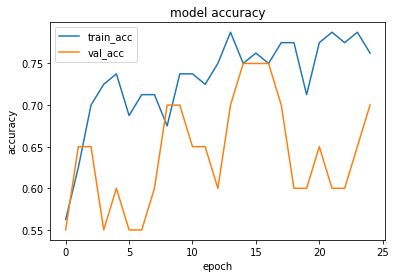

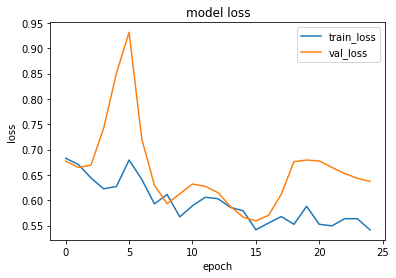

1it [00:00, 16131.94it/s]
file is another_control.mov, prediction is [[0.17706451]]
1it [00:00, 14926.35it/s]
file is short_armflapping.mov, prediction is [[0.57223]]
1it [00:00, 14315.03it/s]
file is control_far.mov, prediction is [[0.17399174]]
1it [00:00, 15363.75it/s]
file is long_armflapping.mov, prediction is [[0.18860763]]
1it [00:00, 18236.10it/s]
file is me_reading_control.mov, prediction is [[0.17420349]]
1it [00:00, 15592.21it/s]file is me_armflapping.mov, prediction is [[0.49336374]]
Epoch 1/50
3/3 [==============================] - 0s 123ms/step - loss: 0.5643 - accuracy: 0.7375 - val_loss: 0.5146 - val_accuracy: 0.8500
Epoch 2/50
3/3 [==============================] - 0s 129ms/step - loss: 0.5636 - accuracy: 0.7125 - val_loss: 0.5188 - val_accuracy: 0.8500
Epoch 3/50
3/3 [==============================] - 0s 119ms/step - loss: 0.5509 - accuracy: 0.7500 - val_loss: 0.5211 - val_accuracy: 0.8500
Epoch 4/50
3/3 [==============================] - 0s 176ms/step - loss: 0.5630 

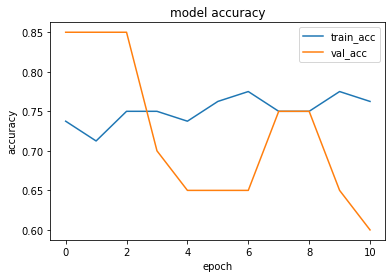

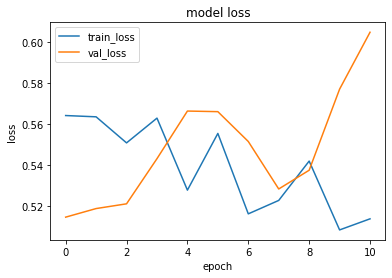

1it [00:00, 12192.74it/s]
file is another_control.mov, prediction is [[0.21537346]]
1it [00:00, 15650.39it/s]
file is short_armflapping.mov, prediction is [[0.75531334]]
1it [00:00, 15141.89it/s]
file is control_far.mov, prediction is [[0.20888802]]
1it [00:00, 18893.26it/s]
file is long_armflapping.mov, prediction is [[0.25043678]]
1it [00:00, 8473.34it/s]
file is me_reading_control.mov, prediction is [[0.22196737]]
1it [00:00, 14716.86it/s]
file is me_armflapping.mov, prediction is [[0.761023]]
Epoch 1/50
3/3 [==============================] - 0s 162ms/step - loss: 0.5194 - accuracy: 0.7250 - val_loss: 0.5094 - val_accuracy: 0.8000
Epoch 2/50
3/3 [==============================] - 0s 134ms/step - loss: 0.5297 - accuracy: 0.7750 - val_loss: 0.5163 - val_accuracy: 0.8000
Epoch 3/50
3/3 [==============================] - 0s 133ms/step - loss: 0.5093 - accuracy: 0.8000 - val_loss: 0.5158 - val_accuracy: 0.8000
Epoch 4/50
3/3 [==============================] - 0s 135ms/step - loss: 0.5133

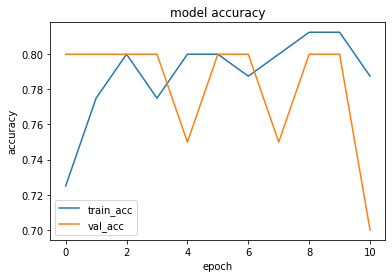

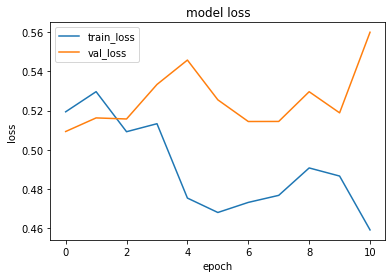

1it [00:00, 18157.16it/s]
file is another_control.mov, prediction is [[0.29232913]]
1it [00:00, 14513.16it/s]
file is short_armflapping.mov, prediction is [[0.76183325]]
1it [00:00, 17623.13it/s]
file is control_far.mov, prediction is [[0.26905358]]
1it [00:00, 16448.25it/s]
file is long_armflapping.mov, prediction is [[0.46040976]]
1it [00:00, 17848.10it/s]
file is me_reading_control.mov, prediction is [[0.2650615]]
1it [00:00, 15141.89it/s]
file is me_armflapping.mov, prediction is [[0.77072716]]
Epoch 1/50
3/3 [==============================] - 0s 123ms/step - loss: 0.6381 - accuracy: 0.7000 - val_loss: 0.5523 - val_accuracy: 0.7500
Epoch 2/50
3/3 [==============================] - 0s 140ms/step - loss: 0.5207 - accuracy: 0.7500 - val_loss: 0.4631 - val_accuracy: 0.8000
Epoch 3/50
3/3 [==============================] - 0s 133ms/step - loss: 0.5176 - accuracy: 0.7625 - val_loss: 0.4243 - val_accuracy: 0.8000
Epoch 4/50
3/3 [==============================] - 0s 121ms/step - loss: 0.48

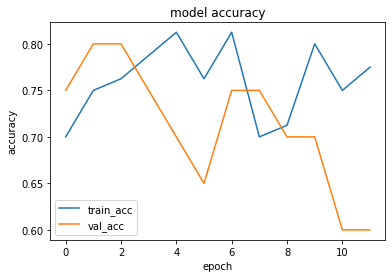

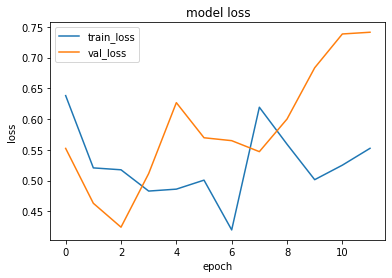

1it [00:00, 15363.75it/s]
file is another_control.mov, prediction is [[0.30206138]]
1it [00:00, 15141.89it/s]
file is short_armflapping.mov, prediction is [[0.70096916]]
1it [00:00, 16578.28it/s]
file is control_far.mov, prediction is [[0.29669878]]
1it [00:00, 17772.47it/s]
file is long_armflapping.mov, prediction is [[0.31857228]]
1it [00:00, 16194.22it/s]
file is me_reading_control.mov, prediction is [[0.29372418]]
1it [00:00, 13888.42it/s]
file is me_armflapping.mov, prediction is [[0.6676922]]
Epoch 1/50
3/3 [==============================] - 0s 145ms/step - loss: 0.5706 - accuracy: 0.7000 - val_loss: 0.5518 - val_accuracy: 0.8000
Epoch 2/50
3/3 [==============================] - 0s 137ms/step - loss: 0.5772 - accuracy: 0.6625 - val_loss: 0.5289 - val_accuracy: 0.7500
Epoch 3/50
3/3 [==============================] - 0s 120ms/step - loss: 0.5293 - accuracy: 0.7250 - val_loss: 0.5167 - val_accuracy: 0.8000
Epoch 4/50
3/3 [==============================] - 0s 123ms/step - loss: 0.49

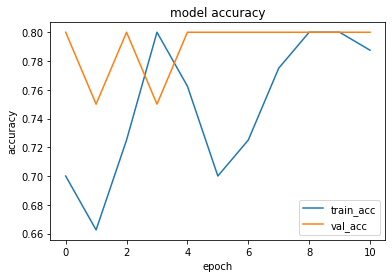

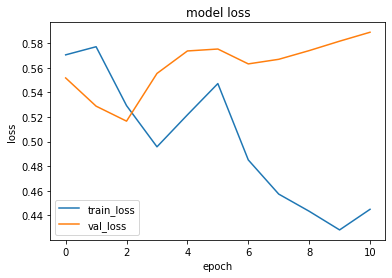

1it [00:00, 15420.24it/s]
file is another_control.mov, prediction is [[0.39675564]]
1it [00:00, 18558.87it/s]
file is short_armflapping.mov, prediction is [[0.7024335]]
1it [00:00, 14716.86it/s]
file is control_far.mov, prediction is [[0.3828537]]
1it [00:00, 16131.94it/s]
file is long_armflapping.mov, prediction is [[0.46736887]]
1it [00:00, 15363.75it/s]
file is me_reading_control.mov, prediction is [[0.37679356]]
1it [00:00, 15887.52it/s]
file is me_armflapping.mov, prediction is [[0.6849789]]
using no aug with lr 0.001
Epoch 1/50
3/3 [==============================] - 1s 228ms/step - loss: 0.6940 - accuracy: 0.5750 - val_loss: 0.7007 - val_accuracy: 0.5000
Epoch 2/50
3/3 [==============================] - 0s 127ms/step - loss: 0.6912 - accuracy: 0.5625 - val_loss: 0.6997 - val_accuracy: 0.5000
Epoch 3/50
3/3 [==============================] - 0s 123ms/step - loss: 0.6896 - accuracy: 0.6500 - val_loss: 0.6990 - val_accuracy: 0.4500
Epoch 4/50
3/3 [==============================] - 0

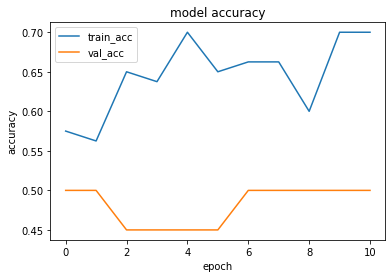

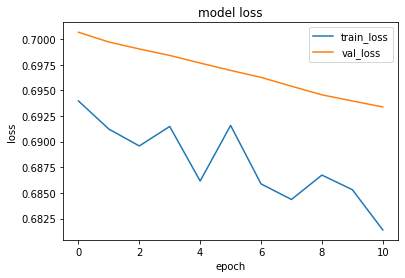

1it [00:00, 15363.75it/s]
file is another_control.mov, prediction is [[0.48419294]]
1it [00:00, 14926.35it/s]
file is short_armflapping.mov, prediction is [[0.48859552]]
1it [00:00, 14122.24it/s]
file is control_far.mov, prediction is [[0.4832618]]
1it [00:00, 14716.86it/s]
file is long_armflapping.mov, prediction is [[0.48725244]]
1it [00:00, 15887.52it/s]
file is me_reading_control.mov, prediction is [[0.48242983]]
1it [00:00, 15887.52it/s]
file is me_armflapping.mov, prediction is [[0.48855466]]
Epoch 1/50
3/3 [==============================] - 0s 147ms/step - loss: 0.6792 - accuracy: 0.6250 - val_loss: 0.6773 - val_accuracy: 0.6500
Epoch 2/50
3/3 [==============================] - 0s 126ms/step - loss: 0.6848 - accuracy: 0.5875 - val_loss: 0.6755 - val_accuracy: 0.7000
Epoch 3/50
3/3 [==============================] - 0s 141ms/step - loss: 0.6892 - accuracy: 0.6125 - val_loss: 0.6738 - val_accuracy: 0.7500
Epoch 4/50
3/3 [==============================] - 0s 121ms/step - loss: 0.68

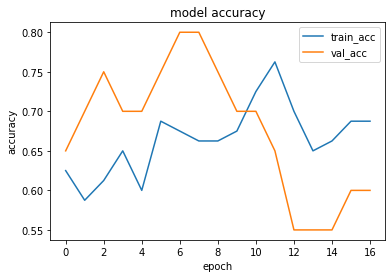

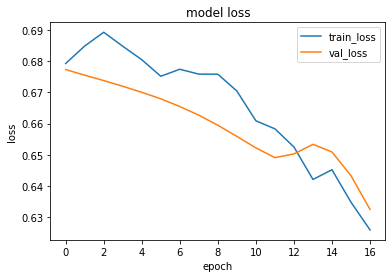

1it [00:00, 14979.66it/s]
file is another_control.mov, prediction is [[0.47621268]]
1it [00:00, 15827.56it/s]
file is short_armflapping.mov, prediction is [[0.5194896]]
1it [00:00, 14665.40it/s]
file is control_far.mov, prediction is [[0.47311372]]
1it [00:00, 16384.00it/s]
file is long_armflapping.mov, prediction is [[0.49182305]]
1it [00:00, 15420.24it/s]
file is me_reading_control.mov, prediction is [[0.4688673]]
1it [00:00, 13934.56it/s]
file is me_armflapping.mov, prediction is [[0.51876277]]
Epoch 1/50
3/3 [==============================] - 0s 150ms/step - loss: 0.6304 - accuracy: 0.6625 - val_loss: 0.6010 - val_accuracy: 0.8000
Epoch 2/50
3/3 [==============================] - 0s 141ms/step - loss: 0.6253 - accuracy: 0.6625 - val_loss: 0.6012 - val_accuracy: 0.7500
Epoch 3/50
3/3 [==============================] - 0s 148ms/step - loss: 0.6297 - accuracy: 0.6750 - val_loss: 0.6018 - val_accuracy: 0.7500
Epoch 4/50
3/3 [==============================] - 0s 140ms/step - loss: 0.632

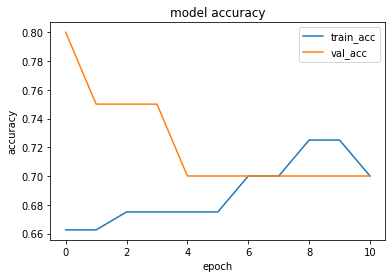

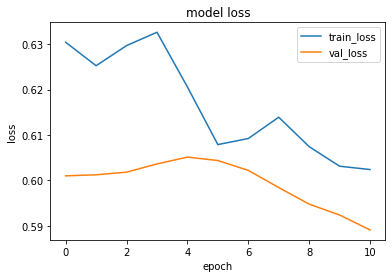

1it [00:00, 14665.40it/s]
file is another_control.mov, prediction is [[0.39625075]]
1it [00:00, 18157.16it/s]
file is short_armflapping.mov, prediction is [[0.45379204]]
1it [00:00, 14926.35it/s]
file is control_far.mov, prediction is [[0.3930515]]
1it [00:00, 14873.42it/s]
file is long_armflapping.mov, prediction is [[0.41191208]]
1it [00:00, 17476.27it/s]
file is me_reading_control.mov, prediction is [[0.39056838]]
1it [00:00, 15087.42it/s]
file is me_armflapping.mov, prediction is [[0.45454356]]
Epoch 1/50
3/3 [==============================] - 0s 133ms/step - loss: 0.5998 - accuracy: 0.6875 - val_loss: 0.6137 - val_accuracy: 0.6500
Epoch 2/50
3/3 [==============================] - 0s 124ms/step - loss: 0.5923 - accuracy: 0.7000 - val_loss: 0.6098 - val_accuracy: 0.6500
Epoch 3/50
3/3 [==============================] - 0s 123ms/step - loss: 0.5986 - accuracy: 0.7125 - val_loss: 0.6084 - val_accuracy: 0.6500
Epoch 4/50
3/3 [==============================] - 0s 130ms/step - loss: 0.59

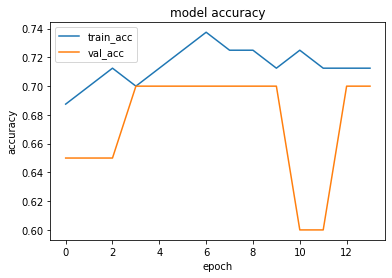

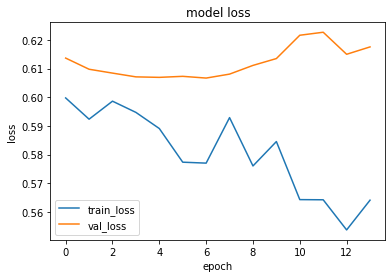

1it [00:00, 13662.23it/s]
file is another_control.mov, prediction is [[0.34099704]]
1it [00:00, 16912.52it/s]
file is short_armflapping.mov, prediction is [[0.36741036]]
1it [00:00, 14463.12it/s]
file is control_far.mov, prediction is [[0.33897045]]
1it [00:00, 14463.12it/s]
file is long_armflapping.mov, prediction is [[0.35079402]]
1it [00:00, 14074.85it/s]
file is me_reading_control.mov, prediction is [[0.33690733]]
1it [00:00, 14266.34it/s]
file is me_armflapping.mov, prediction is [[0.37645704]]
Epoch 1/50
3/3 [==============================] - 0s 142ms/step - loss: 0.5868 - accuracy: 0.7125 - val_loss: 0.5722 - val_accuracy: 0.7500
Epoch 2/50
3/3 [==============================] - 0s 136ms/step - loss: 0.5787 - accuracy: 0.7125 - val_loss: 0.5828 - val_accuracy: 0.7500
Epoch 3/50
3/3 [==============================] - 0s 127ms/step - loss: 0.5684 - accuracy: 0.7000 - val_loss: 0.5903 - val_accuracy: 0.7500
Epoch 4/50
3/3 [==============================] - 0s 132ms/step - loss: 0.5

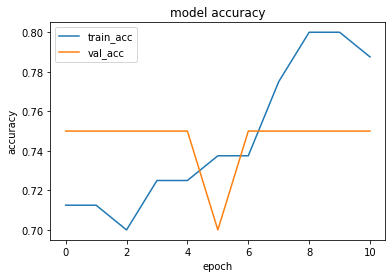

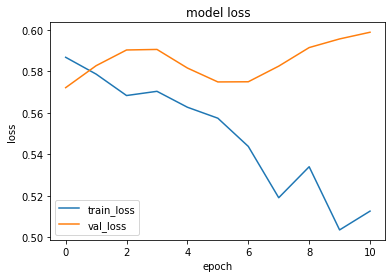

1it [00:00, 15363.75it/s]
file is another_control.mov, prediction is [[0.33881617]]
1it [00:00, 15592.21it/s]
file is short_armflapping.mov, prediction is [[0.37260008]]
1it [00:00, 18157.16it/s]
file is control_far.mov, prediction is [[0.33641833]]
1it [00:00, 5108.77it/s]
file is long_armflapping.mov, prediction is [[0.35008052]]
1it [00:00, 15592.21it/s]
file is me_reading_control.mov, prediction is [[0.33531693]]
1it [00:00, 15887.52it/s]
file is me_armflapping.mov, prediction is [[0.38374907]]
using no aug with lr 0.0005
Epoch 1/50
3/3 [==============================] - 1s 213ms/step - loss: 0.6964 - accuracy: 0.6000 - val_loss: 0.7064 - val_accuracy: 0.5000
Epoch 2/50
3/3 [==============================] - 0s 144ms/step - loss: 0.6971 - accuracy: 0.6250 - val_loss: 0.7057 - val_accuracy: 0.5500
Epoch 3/50
3/3 [==============================] - 0s 145ms/step - loss: 0.6952 - accuracy: 0.6500 - val_loss: 0.7051 - val_accuracy: 0.5500
Epoch 4/50
3/3 [==============================] 

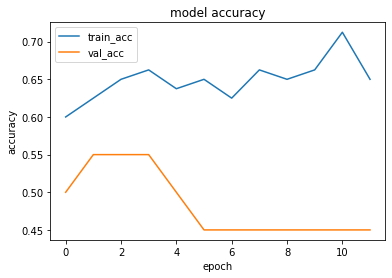

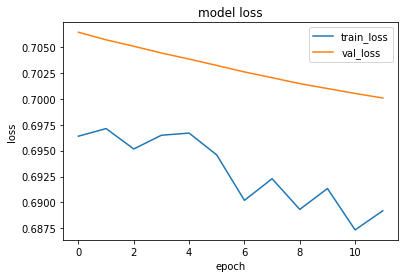

1it [00:00, 17260.51it/s]
file is another_control.mov, prediction is [[0.49391505]]
1it [00:00, 14873.42it/s]
file is short_armflapping.mov, prediction is [[0.50720894]]
1it [00:00, 11618.57it/s]
file is control_far.mov, prediction is [[0.49292928]]
1it [00:00, 14665.40it/s]
file is long_armflapping.mov, prediction is [[0.4967309]]
1it [00:00, 14266.34it/s]
file is me_reading_control.mov, prediction is [[0.4923851]]
1it [00:00, 14716.86it/s]
file is me_armflapping.mov, prediction is [[0.49912816]]
Epoch 1/50
3/3 [==============================] - 1s 189ms/step - loss: 0.6937 - accuracy: 0.5750 - val_loss: 0.6893 - val_accuracy: 0.7000
Epoch 2/50
3/3 [==============================] - 0s 160ms/step - loss: 0.6861 - accuracy: 0.6375 - val_loss: 0.6885 - val_accuracy: 0.7000
Epoch 3/50
3/3 [==============================] - 0s 163ms/step - loss: 0.6911 - accuracy: 0.5750 - val_loss: 0.6878 - val_accuracy: 0.7000
Epoch 4/50
3/3 [==============================] - 0s 176ms/step - loss: 0.696

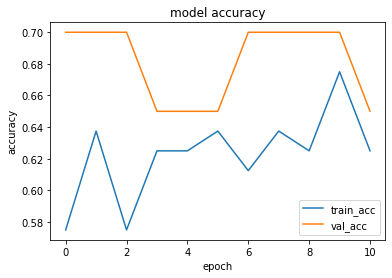

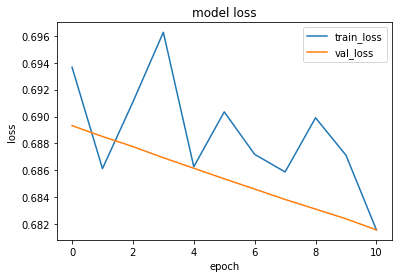

1it [00:00, 17549.39it/s]
file is another_control.mov, prediction is [[0.49410507]]
1it [00:00, 13486.51it/s]
file is short_armflapping.mov, prediction is [[0.513467]]
1it [00:00, 17476.27it/s]
file is control_far.mov, prediction is [[0.4921292]]
1it [00:00, 15650.39it/s]
file is long_armflapping.mov, prediction is [[0.50009954]]
1it [00:00, 17623.13it/s]
file is me_reading_control.mov, prediction is [[0.4909729]]
1it [00:00, 14716.86it/s]
file is me_armflapping.mov, prediction is [[0.50927085]]
Epoch 1/50
3/3 [==============================] - 0s 146ms/step - loss: 0.6895 - accuracy: 0.5875 - val_loss: 0.6796 - val_accuracy: 0.7000
Epoch 2/50
3/3 [==============================] - 0s 133ms/step - loss: 0.6813 - accuracy: 0.6250 - val_loss: 0.6787 - val_accuracy: 0.7000
Epoch 3/50
3/3 [==============================] - 0s 134ms/step - loss: 0.6832 - accuracy: 0.6125 - val_loss: 0.6781 - val_accuracy: 0.7000
Epoch 4/50
3/3 [==============================] - 0s 139ms/step - loss: 0.6811 

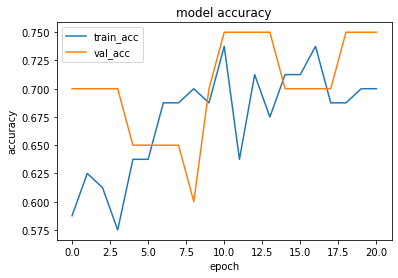

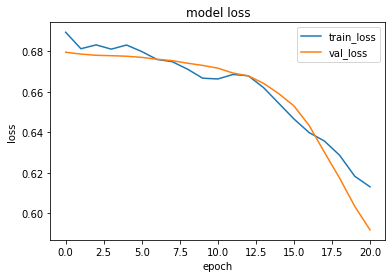

1it [00:00, 15887.52it/s]
file is another_control.mov, prediction is [[0.3954081]]
1it [00:00, 18558.87it/s]
file is short_armflapping.mov, prediction is [[0.51368314]]
1it [00:00, 15592.21it/s]
file is control_far.mov, prediction is [[0.38723305]]
1it [00:00, 16070.13it/s]
file is long_armflapping.mov, prediction is [[0.42603475]]
1it [00:00, 16448.25it/s]
file is me_reading_control.mov, prediction is [[0.39912185]]
1it [00:00, 14716.86it/s]
file is me_armflapping.mov, prediction is [[0.50971043]]
Epoch 1/50
3/3 [==============================] - 0s 159ms/step - loss: 0.5845 - accuracy: 0.7125 - val_loss: 0.6369 - val_accuracy: 0.6500
Epoch 2/50
3/3 [==============================] - 0s 146ms/step - loss: 0.5975 - accuracy: 0.7250 - val_loss: 0.6334 - val_accuracy: 0.6500
Epoch 3/50
3/3 [==============================] - 1s 205ms/step - loss: 0.5883 - accuracy: 0.6875 - val_loss: 0.6458 - val_accuracy: 0.6500
Epoch 4/50
3/3 [==============================] - 0s 147ms/step - loss: 0.58

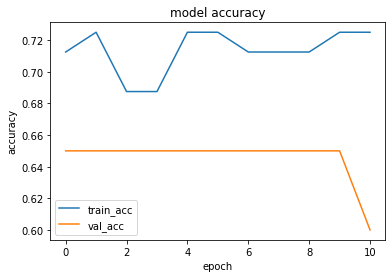

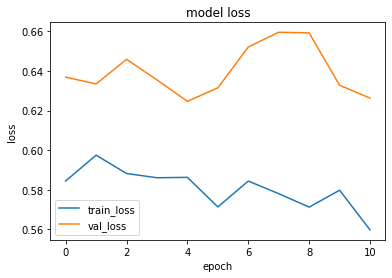

1it [00:00, 18236.10it/s]
file is another_control.mov, prediction is [[0.2922466]]
1it [00:00, 18893.26it/s]
file is short_armflapping.mov, prediction is [[0.34851438]]
1it [00:00, 18477.11it/s]
file is control_far.mov, prediction is [[0.28884888]]
1it [00:00, 14716.86it/s]
file is long_armflapping.mov, prediction is [[0.30535418]]
1it [00:00, 18157.16it/s]
file is me_reading_control.mov, prediction is [[0.2941181]]
1it [00:00, 15887.52it/s]
file is me_armflapping.mov, prediction is [[0.34296316]]
Epoch 1/50
3/3 [==============================] - 0s 163ms/step - loss: 0.5873 - accuracy: 0.6750 - val_loss: 0.5246 - val_accuracy: 0.8000
Epoch 2/50
3/3 [==============================] - 0s 149ms/step - loss: 0.5905 - accuracy: 0.7000 - val_loss: 0.5352 - val_accuracy: 0.7500
Epoch 3/50
3/3 [==============================] - 0s 150ms/step - loss: 0.5785 - accuracy: 0.6750 - val_loss: 0.5506 - val_accuracy: 0.7500
Epoch 4/50
3/3 [==============================] - 0s 153ms/step - loss: 0.594

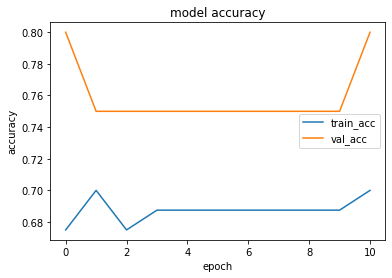

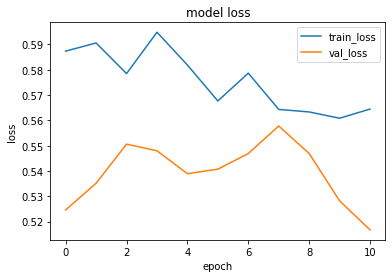

1it [00:00, 15420.24it/s]
file is another_control.mov, prediction is [[0.31658292]]
1it [00:00, 18157.16it/s]
file is short_armflapping.mov, prediction is [[0.43897587]]
1it [00:00, 14463.12it/s]
file is control_far.mov, prediction is [[0.30965823]]
1it [00:00, 15887.52it/s]
file is long_armflapping.mov, prediction is [[0.3429047]]
1it [00:00, 15887.52it/s]
file is me_reading_control.mov, prediction is [[0.32131684]]
1it [00:00, 14873.42it/s]
file is me_armflapping.mov, prediction is [[0.42780462]]
using no aug with lr 0.0001
Epoch 1/50
3/3 [==============================] - 1s 268ms/step - loss: 0.6902 - accuracy: 0.6125 - val_loss: 0.6971 - val_accuracy: 0.5500
Epoch 2/50
3/3 [==============================] - 0s 155ms/step - loss: 0.6895 - accuracy: 0.6750 - val_loss: 0.6970 - val_accuracy: 0.5000
Epoch 3/50
3/3 [==============================] - 0s 174ms/step - loss: 0.6944 - accuracy: 0.6750 - val_loss: 0.6969 - val_accuracy: 0.5000
Epoch 4/50
3/3 [==============================] 

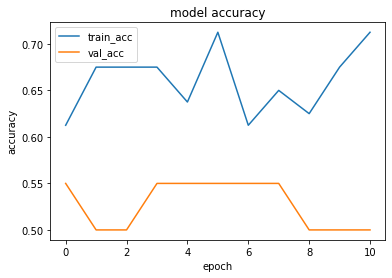

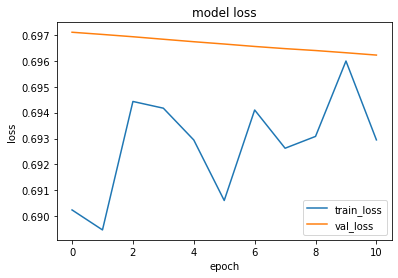

1it [00:00, 12520.31it/s]
file is another_control.mov, prediction is [[0.49919847]]
1it [00:00, 13934.56it/s]
file is short_armflapping.mov, prediction is [[0.50223637]]
1it [00:00, 16980.99it/s]
file is control_far.mov, prediction is [[0.49871]]
1it [00:00, 15420.24it/s]
file is long_armflapping.mov, prediction is [[0.5003956]]
1it [00:00, 17260.51it/s]
file is me_reading_control.mov, prediction is [[0.49864274]]
1it [00:00, 15650.39it/s]
file is me_armflapping.mov, prediction is [[0.5018571]]
Epoch 1/50
3/3 [==============================] - 0s 154ms/step - loss: 0.6944 - accuracy: 0.6000 - val_loss: 0.6912 - val_accuracy: 0.7500
Epoch 2/50
3/3 [==============================] - 0s 158ms/step - loss: 0.6950 - accuracy: 0.5750 - val_loss: 0.6910 - val_accuracy: 0.7500
Epoch 3/50
3/3 [==============================] - 0s 148ms/step - loss: 0.6906 - accuracy: 0.6375 - val_loss: 0.6910 - val_accuracy: 0.7500
Epoch 4/50
3/3 [==============================] - 0s 123ms/step - loss: 0.6932 -

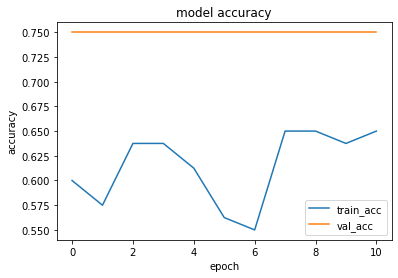

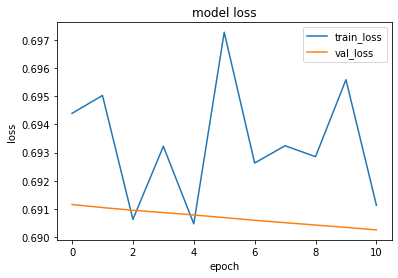

1it [00:00, 14463.12it/s]
file is another_control.mov, prediction is [[0.49924734]]
1it [00:00, 17772.47it/s]
file is short_armflapping.mov, prediction is [[0.5024086]]
1it [00:00, 13530.01it/s]
file is control_far.mov, prediction is [[0.49871802]]
1it [00:00, 13148.29it/s]
file is long_armflapping.mov, prediction is [[0.5005566]]
1it [00:00, 17549.39it/s]
file is me_reading_control.mov, prediction is [[0.49864572]]
1it [00:00, 15363.75it/s]
file is me_armflapping.mov, prediction is [[0.50214183]]
Epoch 1/50
3/3 [==============================] - 0s 149ms/step - loss: 0.6916 - accuracy: 0.6375 - val_loss: 0.6905 - val_accuracy: 0.7000
Epoch 2/50
3/3 [==============================] - 0s 144ms/step - loss: 0.6926 - accuracy: 0.6625 - val_loss: 0.6905 - val_accuracy: 0.7000
Epoch 3/50
3/3 [==============================] - 0s 143ms/step - loss: 0.6891 - accuracy: 0.6125 - val_loss: 0.6904 - val_accuracy: 0.7000
Epoch 4/50
3/3 [==============================] - 0s 146ms/step - loss: 0.692

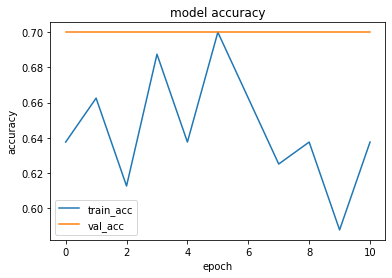

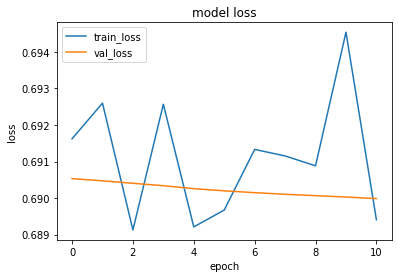

1it [00:00, 17260.51it/s]
file is another_control.mov, prediction is [[0.49851397]]
1it [00:00, 15592.21it/s]
file is short_armflapping.mov, prediction is [[0.50186306]]
1it [00:00, 14513.16it/s]
file is control_far.mov, prediction is [[0.49793807]]
1it [00:00, 14873.42it/s]
file is long_armflapping.mov, prediction is [[0.4999448]]
1it [00:00, 17848.10it/s]
file is me_reading_control.mov, prediction is [[0.49786133]]
1it [00:00, 14716.86it/s]
file is me_armflapping.mov, prediction is [[0.50169325]]
Epoch 1/50
3/3 [==============================] - 0s 146ms/step - loss: 0.6912 - accuracy: 0.6750 - val_loss: 0.6913 - val_accuracy: 0.6500
Epoch 2/50
3/3 [==============================] - 0s 134ms/step - loss: 0.6902 - accuracy: 0.7000 - val_loss: 0.6913 - val_accuracy: 0.6500
Epoch 3/50
3/3 [==============================] - 0s 136ms/step - loss: 0.6891 - accuracy: 0.6750 - val_loss: 0.6913 - val_accuracy: 0.6500
Epoch 4/50
3/3 [==============================] - 0s 146ms/step - loss: 0.68

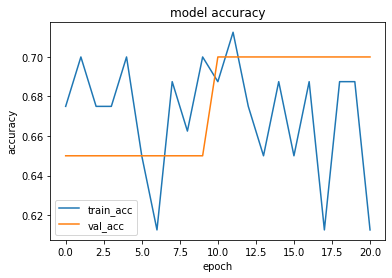

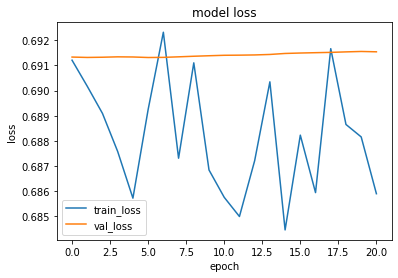

1it [00:00, 16131.94it/s]
file is another_control.mov, prediction is [[0.49968898]]
1it [00:00, 16912.52it/s]
file is short_armflapping.mov, prediction is [[0.50320655]]
1it [00:00, 17623.13it/s]
file is control_far.mov, prediction is [[0.4989882]]
1it [00:00, 12157.40it/s]
file is long_armflapping.mov, prediction is [[0.5014292]]
1it [00:00, 18236.10it/s]
file is me_reading_control.mov, prediction is [[0.49888858]]
1it [00:00, 15650.39it/s]
file is me_armflapping.mov, prediction is [[0.50376475]]
Epoch 1/50
3/3 [==============================] - 1s 198ms/step - loss: 0.6848 - accuracy: 0.6500 - val_loss: 0.6860 - val_accuracy: 0.7500
Epoch 2/50
3/3 [==============================] - 0s 151ms/step - loss: 0.6897 - accuracy: 0.6125 - val_loss: 0.6859 - val_accuracy: 0.7500
Epoch 3/50
3/3 [==============================] - 0s 143ms/step - loss: 0.6906 - accuracy: 0.6500 - val_loss: 0.6858 - val_accuracy: 0.7500
Epoch 4/50
3/3 [==============================] - 0s 147ms/step - loss: 0.689

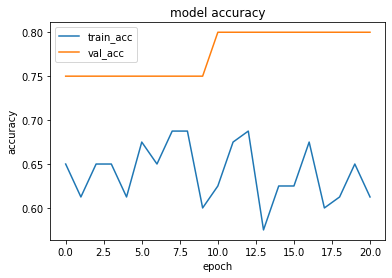

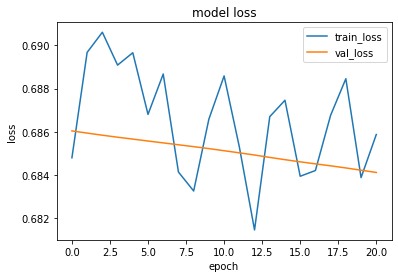

1it [00:00, 14926.35it/s]
file is another_control.mov, prediction is [[0.5006328]]
1it [00:00, 16710.37it/s]
file is short_armflapping.mov, prediction is [[0.5040311]]
1it [00:00, 16644.06it/s]
file is control_far.mov, prediction is [[0.49984026]]
1it [00:00, 14926.35it/s]
file is long_armflapping.mov, prediction is [[0.50258744]]
1it [00:00, 16980.99it/s]
file is me_reading_control.mov, prediction is [[0.49971968]]
1it [00:00, 17331.83it/s]
file is me_armflapping.mov, prediction is [[0.5051394]]
using aug with lr 0.01
Epoch 1/50
3/3 [==============================] - 1s 220ms/step - loss: 0.6913 - accuracy: 0.5750 - val_loss: 0.6975 - val_accuracy: 0.4500
Epoch 2/50
3/3 [==============================] - 0s 140ms/step - loss: 0.6730 - accuracy: 0.6375 - val_loss: 0.6874 - val_accuracy: 0.5500
Epoch 3/50
3/3 [==============================] - 0s 135ms/step - loss: 0.6568 - accuracy: 0.6875 - val_loss: 0.6779 - val_accuracy: 0.6000
Epoch 4/50
3/3 [==============================] - 0s 13

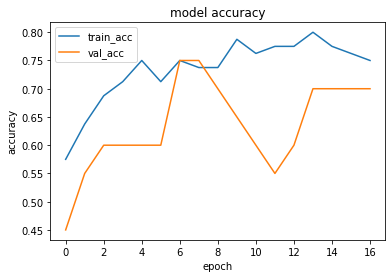

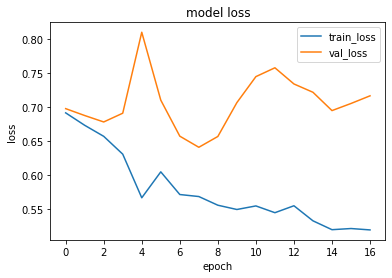

1it [00:00, 17476.27it/s]
file is another_control.mov, prediction is [[0.18105558]]
1it [00:00, 17189.77it/s]
file is short_armflapping.mov, prediction is [[0.6143082]]
1it [00:00, 16131.94it/s]
file is control_far.mov, prediction is [[0.16006672]]
1it [00:00, 17623.13it/s]
file is long_armflapping.mov, prediction is [[0.39371654]]
1it [00:00, 15887.52it/s]
file is me_reading_control.mov, prediction is [[0.1388947]]
1it [00:00, 16131.94it/s]
file is me_armflapping.mov, prediction is [[0.7788444]]
Epoch 1/50
3/3 [==============================] - 0s 155ms/step - loss: 0.5622 - accuracy: 0.7625 - val_loss: 0.4946 - val_accuracy: 0.8000
Epoch 2/50
3/3 [==============================] - 0s 149ms/step - loss: 0.5564 - accuracy: 0.7500 - val_loss: 0.5478 - val_accuracy: 0.7500
Epoch 3/50
3/3 [==============================] - 0s 124ms/step - loss: 0.5592 - accuracy: 0.7375 - val_loss: 0.6063 - val_accuracy: 0.7000
Epoch 4/50
3/3 [==============================] - 0s 148ms/step - loss: 0.5257

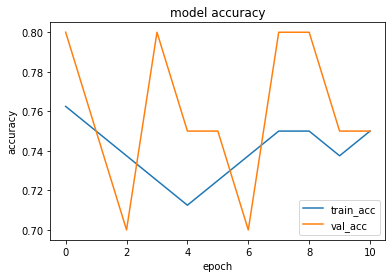

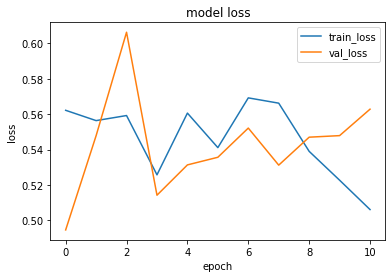

1it [00:00, 14463.12it/s]
file is another_control.mov, prediction is [[0.32570797]]
1it [00:00, 17924.38it/s]
file is short_armflapping.mov, prediction is [[0.80803704]]
1it [00:00, 18157.16it/s]
file is control_far.mov, prediction is [[0.24598366]]
1it [00:00, 15420.24it/s]
file is long_armflapping.mov, prediction is [[0.6481786]]
1it [00:00, 16384.00it/s]
file is me_reading_control.mov, prediction is [[0.24982631]]
1it [00:00, 14266.34it/s]
file is me_armflapping.mov, prediction is [[0.8359512]]
Epoch 1/50
3/3 [==============================] - 0s 183ms/step - loss: 0.5426 - accuracy: 0.7625 - val_loss: 0.3602 - val_accuracy: 0.8500
Epoch 2/50
3/3 [==============================] - 0s 158ms/step - loss: 0.5267 - accuracy: 0.7875 - val_loss: 0.3966 - val_accuracy: 0.8500
Epoch 3/50
3/3 [==============================] - 0s 144ms/step - loss: 0.5400 - accuracy: 0.7750 - val_loss: 0.4310 - val_accuracy: 0.8500
Epoch 4/50
3/3 [==============================] - 0s 166ms/step - loss: 0.487

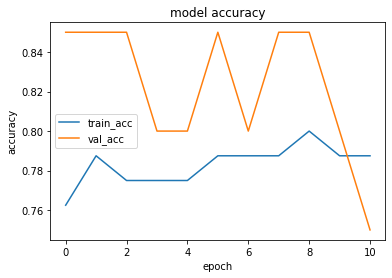

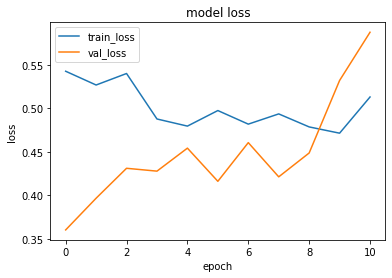

1it [00:00, 13706.88it/s]
file is another_control.mov, prediction is [[0.2954622]]
1it [00:00, 17260.51it/s]
file is short_armflapping.mov, prediction is [[0.87081426]]
1it [00:00, 15592.21it/s]
file is control_far.mov, prediction is [[0.1767585]]
1it [00:00, 17260.51it/s]
file is long_armflapping.mov, prediction is [[0.7531854]]
1it [00:00, 17848.10it/s]
file is me_reading_control.mov, prediction is [[0.19824672]]
1it [00:00, 14926.35it/s]
file is me_armflapping.mov, prediction is [[0.83575]]
Epoch 1/50
3/3 [==============================] - 0s 152ms/step - loss: 0.5464 - accuracy: 0.7625 - val_loss: 0.8539 - val_accuracy: 0.5000
Epoch 2/50
3/3 [==============================] - 0s 133ms/step - loss: 0.7169 - accuracy: 0.6000 - val_loss: 0.8421 - val_accuracy: 0.5000
Epoch 3/50
3/3 [==============================] - 0s 147ms/step - loss: 0.6818 - accuracy: 0.6375 - val_loss: 0.7396 - val_accuracy: 0.5500
Epoch 4/50
3/3 [==============================] - 0s 151ms/step - loss: 0.6206 - 

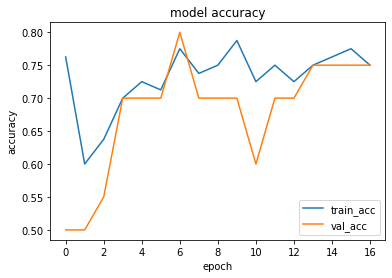

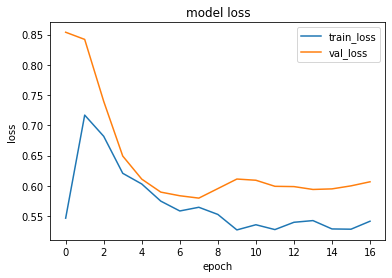

1it [00:00, 16710.37it/s]
file is another_control.mov, prediction is [[0.26314104]]
1it [00:00, 18157.16it/s]
file is short_armflapping.mov, prediction is [[0.59661615]]
1it [00:00, 16194.22it/s]
file is control_far.mov, prediction is [[0.198134]]
1it [00:00, 15363.75it/s]
file is long_armflapping.mov, prediction is [[0.3746552]]
1it [00:00, 16980.99it/s]
file is me_reading_control.mov, prediction is [[0.21930468]]
1it [00:00, 16384.00it/s]
file is me_armflapping.mov, prediction is [[0.7614243]]
Epoch 1/50
3/3 [==============================] - 0s 158ms/step - loss: 0.5523 - accuracy: 0.7375 - val_loss: 0.4642 - val_accuracy: 0.8000
Epoch 2/50
3/3 [==============================] - 0s 124ms/step - loss: 0.5415 - accuracy: 0.7625 - val_loss: 0.4798 - val_accuracy: 0.8000
Epoch 3/50
3/3 [==============================] - 1s 228ms/step - loss: 0.5646 - accuracy: 0.7750 - val_loss: 0.5067 - val_accuracy: 0.7500
Epoch 4/50
3/3 [==============================] - 0s 168ms/step - loss: 0.5486 

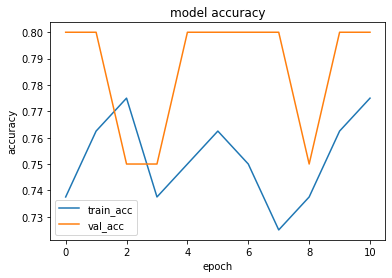

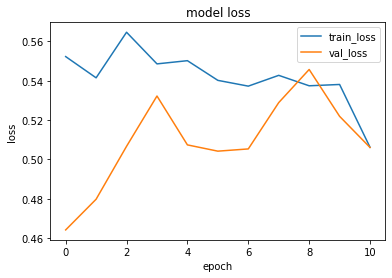

1it [00:00, 12018.06it/s]
file is another_control.mov, prediction is [[0.3432305]]
1it [00:00, 13530.01it/s]
file is short_armflapping.mov, prediction is [[0.5641401]]
1it [00:00, 14665.40it/s]
file is control_far.mov, prediction is [[0.24737617]]
1it [00:00, 13662.23it/s]
file is long_armflapping.mov, prediction is [[0.45876646]]
1it [00:00, 14315.03it/s]
file is me_reading_control.mov, prediction is [[0.3082332]]
1it [00:00, 16448.25it/s]
file is me_armflapping.mov, prediction is [[0.78524554]]
using aug with lr 0.001
Epoch 1/50
3/3 [==============================] - 1s 261ms/step - loss: 0.6946 - accuracy: 0.5000 - val_loss: 0.6844 - val_accuracy: 0.4500
Epoch 2/50
3/3 [==============================] - 0s 156ms/step - loss: 0.6897 - accuracy: 0.6000 - val_loss: 0.6826 - val_accuracy: 0.5500
Epoch 3/50
3/3 [==============================] - 0s 151ms/step - loss: 0.6875 - accuracy: 0.5750 - val_loss: 0.6812 - val_accuracy: 0.5500
Epoch 4/50
3/3 [==============================] - 0s 1

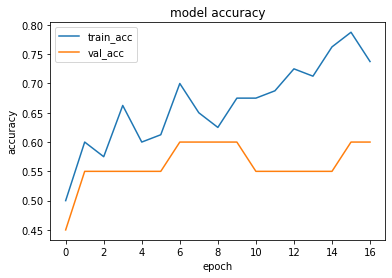

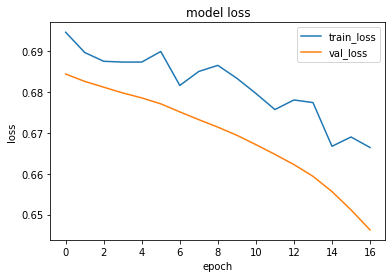

1it [00:00, 15141.89it/s]
file is another_control.mov, prediction is [[0.48744118]]
1it [00:00, 14266.34it/s]
file is short_armflapping.mov, prediction is [[0.5045859]]
1it [00:00, 14266.34it/s]
file is control_far.mov, prediction is [[0.48562464]]
1it [00:00, 14716.86it/s]
file is long_armflapping.mov, prediction is [[0.49323875]]
1it [00:00, 16131.94it/s]
file is me_reading_control.mov, prediction is [[0.48454845]]
1it [00:00, 14463.12it/s]
file is me_armflapping.mov, prediction is [[0.5105282]]
Epoch 1/50
3/3 [==============================] - 0s 158ms/step - loss: 0.6713 - accuracy: 0.6875 - val_loss: 0.6456 - val_accuracy: 0.7500
Epoch 2/50
3/3 [==============================] - 0s 127ms/step - loss: 0.6593 - accuracy: 0.7000 - val_loss: 0.6394 - val_accuracy: 0.8000
Epoch 3/50
3/3 [==============================] - 0s 139ms/step - loss: 0.6571 - accuracy: 0.7000 - val_loss: 0.6331 - val_accuracy: 0.7000
Epoch 4/50
3/3 [==============================] - 0s 143ms/step - loss: 0.643

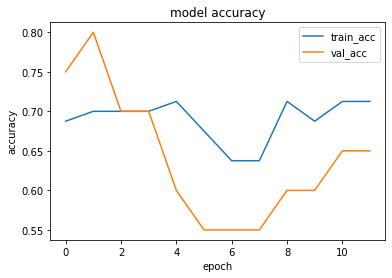

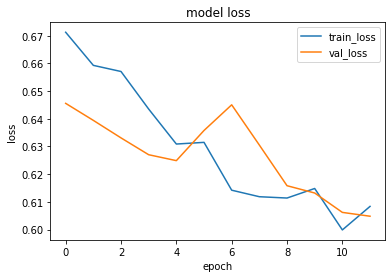

1it [00:00, 15141.89it/s]
file is another_control.mov, prediction is [[0.4453818]]
1it [00:00, 17260.51it/s]
file is short_armflapping.mov, prediction is [[0.5491878]]
1it [00:00, 14873.42it/s]
file is control_far.mov, prediction is [[0.43796024]]
1it [00:00, 14563.56it/s]
file is long_armflapping.mov, prediction is [[0.4765927]]
1it [00:00, 14979.66it/s]
file is me_reading_control.mov, prediction is [[0.44410735]]
1it [00:00, 14979.66it/s]
file is me_armflapping.mov, prediction is [[0.5737107]]
Epoch 1/50
3/3 [==============================] - 0s 153ms/step - loss: 0.6086 - accuracy: 0.6625 - val_loss: 0.5990 - val_accuracy: 0.7500
Epoch 2/50
3/3 [==============================] - 0s 132ms/step - loss: 0.6019 - accuracy: 0.6625 - val_loss: 0.6009 - val_accuracy: 0.7500
Epoch 3/50
3/3 [==============================] - 0s 158ms/step - loss: 0.6026 - accuracy: 0.6875 - val_loss: 0.6049 - val_accuracy: 0.7500
Epoch 4/50
3/3 [==============================] - 0s 122ms/step - loss: 0.6015 

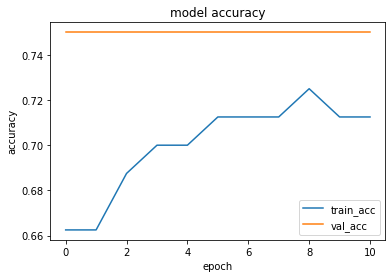

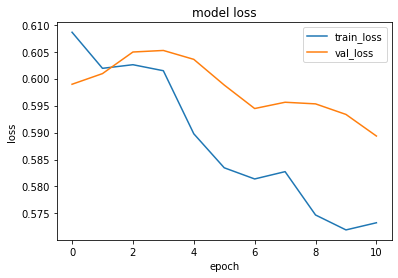

1it [00:00, 14665.40it/s]
file is another_control.mov, prediction is [[0.37464228]]
1it [00:00, 15827.56it/s]
file is short_armflapping.mov, prediction is [[0.50977755]]
1it [00:00, 16131.94it/s]
file is control_far.mov, prediction is [[0.3677114]]
1it [00:00, 16131.94it/s]
file is long_armflapping.mov, prediction is [[0.40961218]]
1it [00:00, 17623.13it/s]
file is me_reading_control.mov, prediction is [[0.36882707]]
1it [00:00, 15196.75it/s]
file is me_armflapping.mov, prediction is [[0.55934817]]
Epoch 1/50
3/3 [==============================] - 1s 239ms/step - loss: 0.5802 - accuracy: 0.7250 - val_loss: 0.6040 - val_accuracy: 0.6500
Epoch 2/50
3/3 [==============================] - 0s 132ms/step - loss: 0.5526 - accuracy: 0.7250 - val_loss: 0.6243 - val_accuracy: 0.6000
Epoch 3/50
3/3 [==============================] - 0s 142ms/step - loss: 0.5525 - accuracy: 0.7250 - val_loss: 0.6245 - val_accuracy: 0.6500
Epoch 4/50
3/3 [==============================] - 0s 146ms/step - loss: 0.55

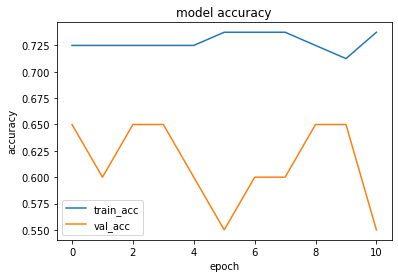

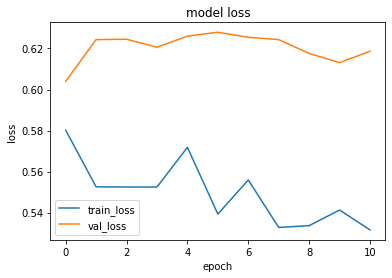

1it [00:00, 16384.00it/s]
file is another_control.mov, prediction is [[0.30710325]]
1it [00:00, 17549.39it/s]
file is short_armflapping.mov, prediction is [[0.41931218]]
1it [00:00, 13617.87it/s]
file is control_far.mov, prediction is [[0.30123472]]
1it [00:00, 14873.42it/s]
file is long_armflapping.mov, prediction is [[0.33632934]]
1it [00:00, 15650.39it/s]
file is me_reading_control.mov, prediction is [[0.30039942]]
1it [00:00, 15592.21it/s]
file is me_armflapping.mov, prediction is [[0.4579104]]
Epoch 1/50
3/3 [==============================] - 0s 166ms/step - loss: 0.5489 - accuracy: 0.7000 - val_loss: 0.5475 - val_accuracy: 0.7500
Epoch 2/50
3/3 [==============================] - 0s 126ms/step - loss: 0.5522 - accuracy: 0.7250 - val_loss: 0.6016 - val_accuracy: 0.7500
Epoch 3/50
3/3 [==============================] - 0s 143ms/step - loss: 0.5318 - accuracy: 0.7375 - val_loss: 0.6172 - val_accuracy: 0.7500
Epoch 4/50
3/3 [==============================] - 0s 150ms/step - loss: 0.54

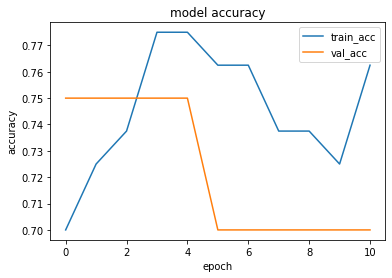

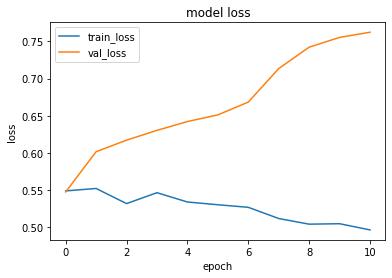

1it [00:00, 14513.16it/s]
file is another_control.mov, prediction is [[0.33648235]]
1it [00:00, 16320.25it/s]
file is short_armflapping.mov, prediction is [[0.5274647]]
1it [00:00, 17848.10it/s]
file is control_far.mov, prediction is [[0.32735586]]
1it [00:00, 17623.13it/s]
file is long_armflapping.mov, prediction is [[0.38509214]]
1it [00:00, 17331.83it/s]
file is me_reading_control.mov, prediction is [[0.32510382]]
1it [00:00, 15650.39it/s]
file is me_armflapping.mov, prediction is [[0.5778115]]
using aug with lr 0.0005
Epoch 1/50
3/3 [==============================] - 1s 223ms/step - loss: 0.6968 - accuracy: 0.5750 - val_loss: 0.6904 - val_accuracy: 0.5000
Epoch 2/50
3/3 [==============================] - 0s 165ms/step - loss: 0.6927 - accuracy: 0.6375 - val_loss: 0.6899 - val_accuracy: 0.5000
Epoch 3/50
3/3 [==============================] - 0s 134ms/step - loss: 0.6922 - accuracy: 0.6750 - val_loss: 0.6894 - val_accuracy: 0.4500
Epoch 4/50
3/3 [==============================] - 1s

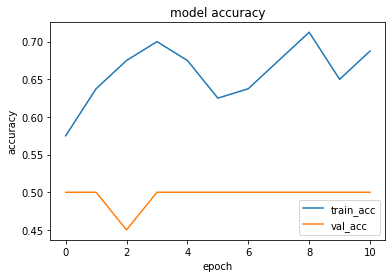

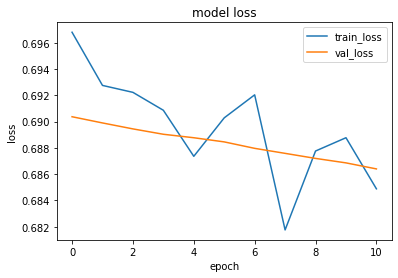

1it [00:00, 14074.85it/s]
file is another_control.mov, prediction is [[0.48944572]]
1it [00:00, 14513.16it/s]
file is short_armflapping.mov, prediction is [[0.5047341]]
1it [00:00, 17848.10it/s]
file is control_far.mov, prediction is [[0.4880371]]
1it [00:00, 14074.85it/s]
file is long_armflapping.mov, prediction is [[0.49305776]]
1it [00:00, 17260.51it/s]
file is me_reading_control.mov, prediction is [[0.4874917]]
1it [00:00, 15887.52it/s]
file is me_armflapping.mov, prediction is [[0.4973993]]
Epoch 1/50
3/3 [==============================] - 0s 168ms/step - loss: 0.6832 - accuracy: 0.6250 - val_loss: 0.6807 - val_accuracy: 0.7000
Epoch 2/50
3/3 [==============================] - 0s 143ms/step - loss: 0.6833 - accuracy: 0.6625 - val_loss: 0.6800 - val_accuracy: 0.7000
Epoch 3/50
3/3 [==============================] - 0s 134ms/step - loss: 0.6831 - accuracy: 0.6375 - val_loss: 0.6792 - val_accuracy: 0.7000
Epoch 4/50
3/3 [==============================] - 0s 153ms/step - loss: 0.6848 

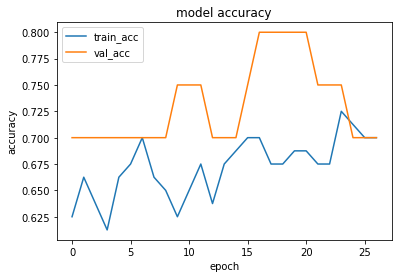

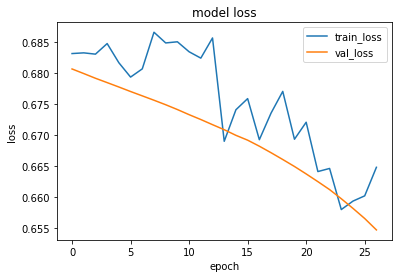

1it [00:00, 13315.25it/s]
file is another_control.mov, prediction is [[0.493253]]
1it [00:00, 12787.51it/s]
file is short_armflapping.mov, prediction is [[0.5212404]]
1it [00:00, 16384.00it/s]
file is control_far.mov, prediction is [[0.48958778]]
1it [00:00, 16980.99it/s]
file is long_armflapping.mov, prediction is [[0.5038057]]
1it [00:00, 14926.35it/s]
file is me_reading_control.mov, prediction is [[0.487395]]
1it [00:00, 9799.78it/s]
file is me_armflapping.mov, prediction is [[0.5215819]]
Epoch 1/50
3/3 [==============================] - 0s 156ms/step - loss: 0.6570 - accuracy: 0.7125 - val_loss: 0.6558 - val_accuracy: 0.7000
Epoch 2/50
3/3 [==============================] - 0s 139ms/step - loss: 0.6519 - accuracy: 0.7375 - val_loss: 0.6533 - val_accuracy: 0.7500
Epoch 3/50
3/3 [==============================] - 0s 151ms/step - loss: 0.6542 - accuracy: 0.6625 - val_loss: 0.6513 - val_accuracy: 0.7500
Epoch 4/50
3/3 [==============================] - 0s 129ms/step - loss: 0.6568 - ac

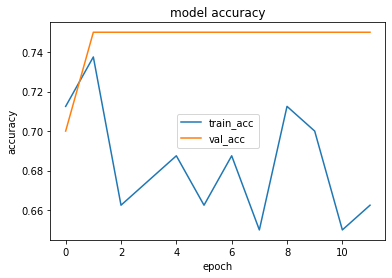

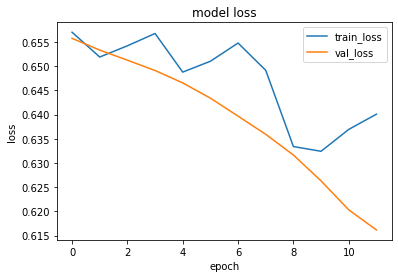

1it [00:00, 16980.99it/s]
file is another_control.mov, prediction is [[0.4686359]]
1it [00:00, 16194.22it/s]
file is short_armflapping.mov, prediction is [[0.5365044]]
1it [00:00, 15363.75it/s]
file is control_far.mov, prediction is [[0.4619398]]
1it [00:00, 15887.52it/s]
file is long_armflapping.mov, prediction is [[0.4936361]]
1it [00:00, 16644.06it/s]
file is me_reading_control.mov, prediction is [[0.46005335]]
1it [00:00, 15650.39it/s]
file is me_armflapping.mov, prediction is [[0.55148125]]
Epoch 1/50
3/3 [==============================] - 0s 147ms/step - loss: 0.6084 - accuracy: 0.7500 - val_loss: 0.6579 - val_accuracy: 0.5500
Epoch 2/50
3/3 [==============================] - 0s 159ms/step - loss: 0.6102 - accuracy: 0.7000 - val_loss: 0.6606 - val_accuracy: 0.5500
Epoch 3/50
3/3 [==============================] - 0s 133ms/step - loss: 0.6114 - accuracy: 0.7250 - val_loss: 0.6687 - val_accuracy: 0.5500
Epoch 4/50
3/3 [==============================] - 0s 135ms/step - loss: 0.6065 

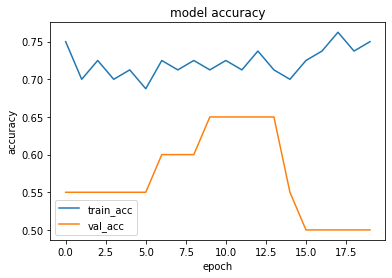

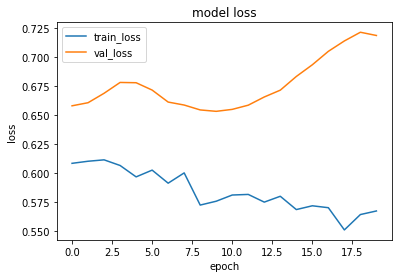

1it [00:00, 15887.52it/s]
file is another_control.mov, prediction is [[0.35237545]]
1it [00:00, 14074.85it/s]
file is short_armflapping.mov, prediction is [[0.4056346]]
1it [00:00, 7397.36it/s]
file is control_far.mov, prediction is [[0.34941787]]
1it [00:00, 13934.56it/s]
file is long_armflapping.mov, prediction is [[0.3666234]]
1it [00:00, 14315.03it/s]
file is me_reading_control.mov, prediction is [[0.34808207]]
1it [00:00, 12520.31it/s]
file is me_armflapping.mov, prediction is [[0.43059316]]
Epoch 1/50
3/3 [==============================] - 0s 161ms/step - loss: 0.6084 - accuracy: 0.6625 - val_loss: 0.5756 - val_accuracy: 0.7500
Epoch 2/50
3/3 [==============================] - 0s 139ms/step - loss: 0.5873 - accuracy: 0.7125 - val_loss: 0.5793 - val_accuracy: 0.7500
Epoch 3/50
3/3 [==============================] - 0s 139ms/step - loss: 0.5722 - accuracy: 0.6875 - val_loss: 0.5799 - val_accuracy: 0.7500
Epoch 4/50
3/3 [==============================] - 0s 130ms/step - loss: 0.5886

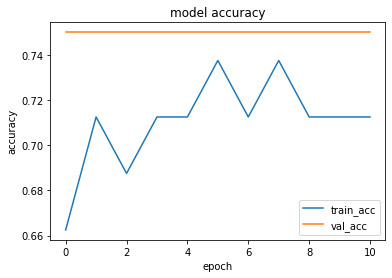

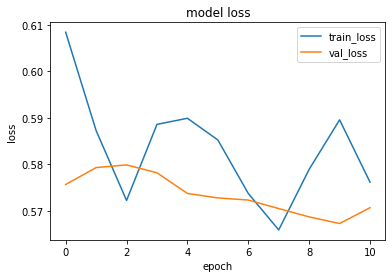

1it [00:00, 14463.12it/s]
file is another_control.mov, prediction is [[0.34728324]]
1it [00:00, 17848.10it/s]
file is short_armflapping.mov, prediction is [[0.42514595]]
1it [00:00, 8192.00it/s]
file is control_far.mov, prediction is [[0.34373862]]
1it [00:00, 13706.88it/s]
file is long_armflapping.mov, prediction is [[0.36612993]]
1it [00:00, 12483.05it/s]
file is me_reading_control.mov, prediction is [[0.34218585]]
1it [00:00, 15477.14it/s]
file is me_armflapping.mov, prediction is [[0.4629375]]
using aug with lr 0.0001
Epoch 1/50
3/3 [==============================] - 1s 234ms/step - loss: 0.6905 - accuracy: 0.5375 - val_loss: 0.6845 - val_accuracy: 0.4500
Epoch 2/50
3/3 [==============================] - 0s 160ms/step - loss: 0.6896 - accuracy: 0.6375 - val_loss: 0.6843 - val_accuracy: 0.5000
Epoch 3/50
3/3 [==============================] - 0s 134ms/step - loss: 0.6899 - accuracy: 0.5750 - val_loss: 0.6842 - val_accuracy: 0.5000
Epoch 4/50
3/3 [==============================] - 1s

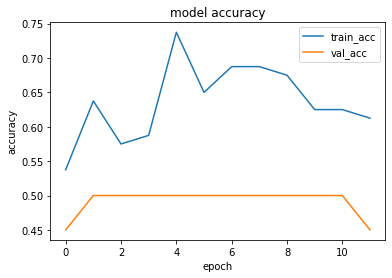

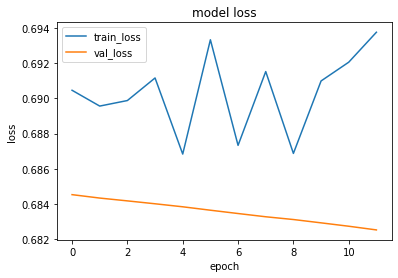

1it [00:00, 15420.24it/s]
file is another_control.mov, prediction is [[0.49928516]]
1it [00:00, 13934.56it/s]
file is short_armflapping.mov, prediction is [[0.49556926]]
1it [00:00, 15650.39it/s]
file is control_far.mov, prediction is [[0.4988818]]
1it [00:00, 14926.35it/s]
file is long_armflapping.mov, prediction is [[0.4999373]]
1it [00:00, 14716.86it/s]
file is me_reading_control.mov, prediction is [[0.4989405]]
1it [00:00, 14463.12it/s]
file is me_armflapping.mov, prediction is [[0.495451]]
Epoch 1/50
3/3 [==============================] - 0s 166ms/step - loss: 0.6895 - accuracy: 0.6000 - val_loss: 0.6848 - val_accuracy: 0.8000
Epoch 2/50
3/3 [==============================] - 0s 148ms/step - loss: 0.6855 - accuracy: 0.5875 - val_loss: 0.6846 - val_accuracy: 0.8000
Epoch 3/50
3/3 [==============================] - 0s 147ms/step - loss: 0.6886 - accuracy: 0.6000 - val_loss: 0.6844 - val_accuracy: 0.8000
Epoch 4/50
3/3 [==============================] - 0s 123ms/step - loss: 0.6847 -

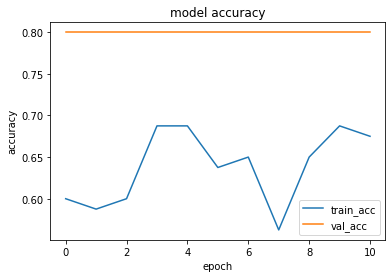

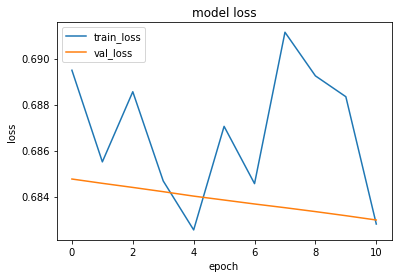

1it [00:00, 11915.64it/s]
file is another_control.mov, prediction is [[0.4998827]]
1it [00:00, 14513.16it/s]
file is short_armflapping.mov, prediction is [[0.4967889]]
1it [00:00, 14926.35it/s]
file is control_far.mov, prediction is [[0.49935836]]
1it [00:00, 16131.94it/s]
file is long_armflapping.mov, prediction is [[0.5008362]]
1it [00:00, 14768.68it/s]
file is me_reading_control.mov, prediction is [[0.49938613]]
1it [00:00, 15363.75it/s]
file is me_armflapping.mov, prediction is [[0.49679065]]
Epoch 1/50
3/3 [==============================] - 1s 178ms/step - loss: 0.6883 - accuracy: 0.6625 - val_loss: 0.6859 - val_accuracy: 0.7000
Epoch 2/50
3/3 [==============================] - 0s 157ms/step - loss: 0.6826 - accuracy: 0.7125 - val_loss: 0.6857 - val_accuracy: 0.7000
Epoch 3/50
3/3 [==============================] - 0s 138ms/step - loss: 0.6847 - accuracy: 0.7000 - val_loss: 0.6856 - val_accuracy: 0.7000
Epoch 4/50
3/3 [==============================] - 0s 137ms/step - loss: 0.6844

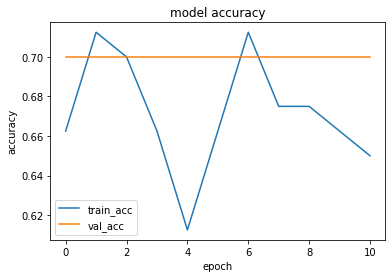

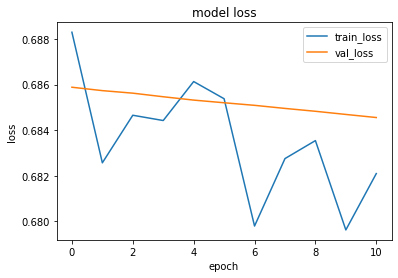

1it [00:00, 14513.16it/s]
file is another_control.mov, prediction is [[0.49928346]]
1it [00:00, 15141.89it/s]
file is short_armflapping.mov, prediction is [[0.4967445]]
1it [00:00, 8004.40it/s]
file is control_far.mov, prediction is [[0.4986669]]
1it [00:00, 13530.01it/s]
file is long_armflapping.mov, prediction is [[0.50047624]]
1it [00:00, 15196.75it/s]
file is me_reading_control.mov, prediction is [[0.49867523]]
1it [00:00, 12633.45it/s]
file is me_armflapping.mov, prediction is [[0.49673268]]
Epoch 1/50
3/3 [==============================] - 0s 151ms/step - loss: 0.6751 - accuracy: 0.6875 - val_loss: 0.6899 - val_accuracy: 0.7000
Epoch 2/50
3/3 [==============================] - 0s 132ms/step - loss: 0.6883 - accuracy: 0.6375 - val_loss: 0.6898 - val_accuracy: 0.7000
Epoch 3/50
3/3 [==============================] - 0s 177ms/step - loss: 0.6847 - accuracy: 0.6625 - val_loss: 0.6897 - val_accuracy: 0.7000
Epoch 4/50
3/3 [==============================] - 0s 140ms/step - loss: 0.6779

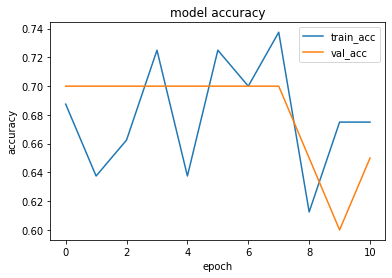

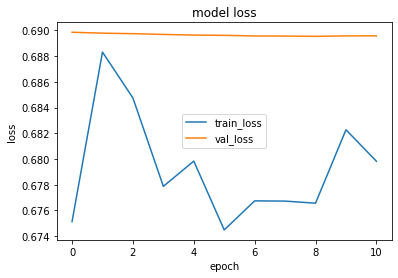

1it [00:00, 12633.45it/s]
file is another_control.mov, prediction is [[0.5002396]]
1it [00:00, 15363.75it/s]
file is short_armflapping.mov, prediction is [[0.49830094]]
1it [00:00, 16131.94it/s]
file is control_far.mov, prediction is [[0.49948913]]
1it [00:00, 14665.40it/s]
file is long_armflapping.mov, prediction is [[0.50176895]]
1it [00:00, 17623.13it/s]
file is me_reading_control.mov, prediction is [[0.4994599]]
1it [00:00, 13357.66it/s]
file is me_armflapping.mov, prediction is [[0.49853855]]
Epoch 1/50
3/3 [==============================] - 0s 141ms/step - loss: 0.6782 - accuracy: 0.7250 - val_loss: 0.6798 - val_accuracy: 0.8000
Epoch 2/50
3/3 [==============================] - 0s 144ms/step - loss: 0.6838 - accuracy: 0.6500 - val_loss: 0.6796 - val_accuracy: 0.8000
Epoch 3/50
3/3 [==============================] - 0s 127ms/step - loss: 0.6796 - accuracy: 0.6375 - val_loss: 0.6794 - val_accuracy: 0.8000
Epoch 4/50
3/3 [==============================] - 0s 133ms/step - loss: 0.681

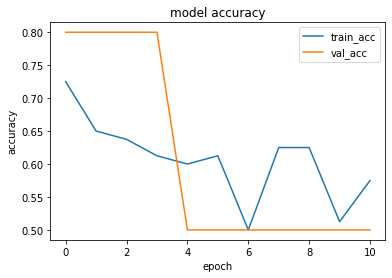

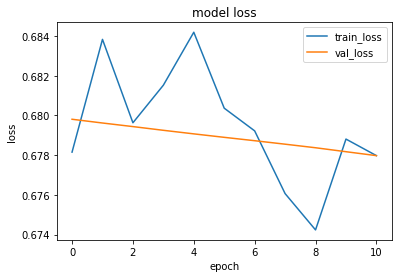

1it [00:00, 15650.39it/s]
file is another_control.mov, prediction is [[0.5018087]]
1it [00:00, 17260.51it/s]
file is short_armflapping.mov, prediction is [[0.50035125]]
1it [00:00, 15592.21it/s]
file is control_far.mov, prediction is [[0.50093603]]
1it [00:00, 13706.88it/s]
file is long_armflapping.mov, prediction is [[0.5036353]]
1it [00:00, 15141.89it/s]
file is me_reading_control.mov, prediction is [[0.5008687]]
1it [00:00, 13357.66it/s]
file is me_armflapping.mov, prediction is [[0.50081843]]
onto model 1
using no aug with lr 0.01
Epoch 1/50
3/3 [==============================] - 1s 249ms/step - loss: 0.6906 - accuracy: 0.5750 - val_loss: 0.6924 - val_accuracy: 0.5500
Epoch 2/50
3/3 [==============================] - 0s 150ms/step - loss: 0.6791 - accuracy: 0.6000 - val_loss: 0.6958 - val_accuracy: 0.5000
Epoch 3/50
3/3 [==============================] - 0s 141ms/step - loss: 0.6716 - accuracy: 0.6625 - val_loss: 0.6983 - val_accuracy: 0.5500
Epoch 4/50
3/3 [=======================

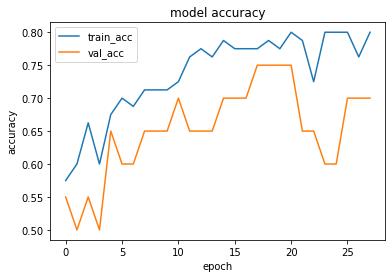

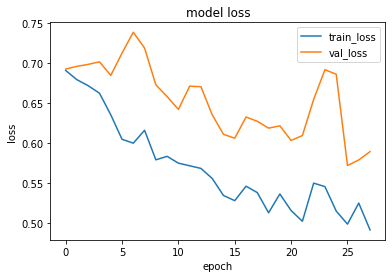

1it [00:00, 14266.34it/s]
file is another_control.mov, prediction is [[0.21870425]]
1it [00:00, 11491.24it/s]
file is short_armflapping.mov, prediction is [[0.7593125]]
1it [00:00, 17549.39it/s]
file is control_far.mov, prediction is [[0.20051566]]
1it [00:00, 14665.40it/s]
file is long_armflapping.mov, prediction is [[0.44608003]]
1it [00:00, 15196.75it/s]
file is me_reading_control.mov, prediction is [[0.19591656]]
1it [00:00, 18157.16it/s]
file is me_armflapping.mov, prediction is [[0.8018397]]
Epoch 1/50
3/3 [==============================] - 1s 198ms/step - loss: 0.5282 - accuracy: 0.7500 - val_loss: 0.4538 - val_accuracy: 0.8500
Epoch 2/50
3/3 [==============================] - 0s 138ms/step - loss: 0.5725 - accuracy: 0.7375 - val_loss: 0.4568 - val_accuracy: 0.8500
Epoch 3/50
3/3 [==============================] - 0s 151ms/step - loss: 0.5999 - accuracy: 0.7125 - val_loss: 0.4654 - val_accuracy: 0.8500
Epoch 4/50
3/3 [==============================] - 0s 134ms/step - loss: 0.551

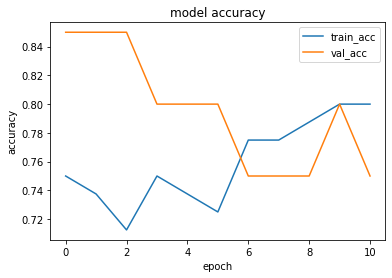

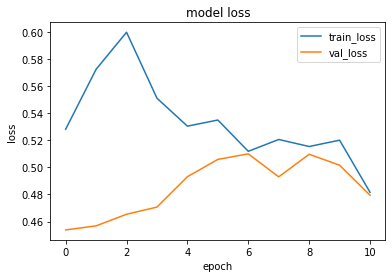

1it [00:00, 15363.75it/s]
file is another_control.mov, prediction is [[0.23190188]]
1it [00:00, 18558.87it/s]
file is short_armflapping.mov, prediction is [[0.78719354]]
1it [00:00, 14768.68it/s]
file is control_far.mov, prediction is [[0.22114629]]
1it [00:00, 15363.75it/s]
file is long_armflapping.mov, prediction is [[0.35093868]]
1it [00:00, 14716.86it/s]
file is me_reading_control.mov, prediction is [[0.21617404]]
1it [00:00, 11748.75it/s]
file is me_armflapping.mov, prediction is [[0.7750255]]
Epoch 1/50
3/3 [==============================] - 0s 170ms/step - loss: 0.4765 - accuracy: 0.7375 - val_loss: 0.4862 - val_accuracy: 0.8500
Epoch 2/50
3/3 [==============================] - 0s 137ms/step - loss: 0.5222 - accuracy: 0.7875 - val_loss: 0.5055 - val_accuracy: 0.8000
Epoch 3/50
3/3 [==============================] - 0s 144ms/step - loss: 0.5142 - accuracy: 0.7625 - val_loss: 0.4959 - val_accuracy: 0.8500
Epoch 4/50
3/3 [==============================] - 0s 134ms/step - loss: 0.47

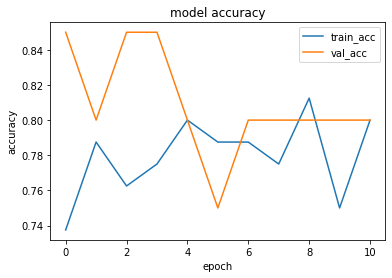

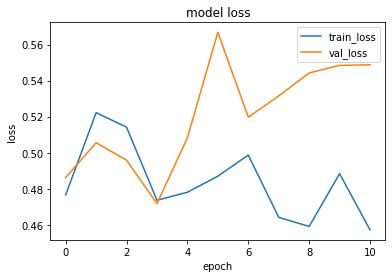

1it [00:00, 15141.89it/s]
file is another_control.mov, prediction is [[0.30173355]]
1it [00:00, 15363.75it/s]
file is short_armflapping.mov, prediction is [[0.5526951]]
1it [00:00, 10082.46it/s]
file is control_far.mov, prediction is [[0.27271992]]
1it [00:00, 11397.57it/s]
file is long_armflapping.mov, prediction is [[0.41975683]]
1it [00:00, 13706.88it/s]
file is me_reading_control.mov, prediction is [[0.2599103]]
1it [00:00, 14563.56it/s]
file is me_armflapping.mov, prediction is [[0.70820534]]
Epoch 1/50
3/3 [==============================] - 0s 171ms/step - loss: 0.4919 - accuracy: 0.7875 - val_loss: 0.4638 - val_accuracy: 0.8000
Epoch 2/50
3/3 [==============================] - 0s 129ms/step - loss: 0.4587 - accuracy: 0.8125 - val_loss: 0.4554 - val_accuracy: 0.8000
Epoch 3/50
3/3 [==============================] - 0s 150ms/step - loss: 0.4870 - accuracy: 0.8000 - val_loss: 0.4562 - val_accuracy: 0.7500
Epoch 4/50
3/3 [==============================] - 0s 135ms/step - loss: 0.449

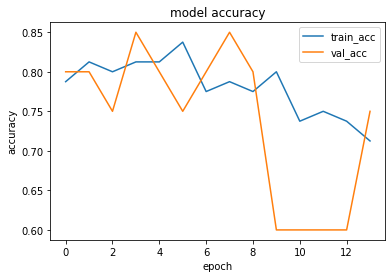

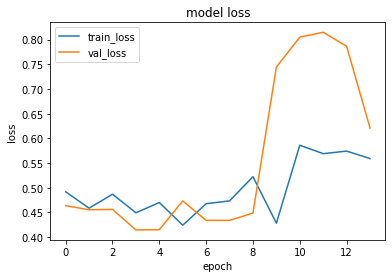

1it [00:00, 3806.08it/s]
file is another_control.mov, prediction is [[0.2622901]]
1it [00:00, 14074.85it/s]
file is short_armflapping.mov, prediction is [[0.53674275]]
1it [00:00, 14926.35it/s]
file is control_far.mov, prediction is [[0.2438916]]
1it [00:00, 11522.81it/s]
file is long_armflapping.mov, prediction is [[0.3291027]]
1it [00:00, 14513.16it/s]
file is me_reading_control.mov, prediction is [[0.23902705]]
1it [00:00, 13315.25it/s]
file is me_armflapping.mov, prediction is [[0.7060708]]
Epoch 1/50
3/3 [==============================] - 0s 173ms/step - loss: 0.5836 - accuracy: 0.7375 - val_loss: 0.4266 - val_accuracy: 0.8500
Epoch 2/50
3/3 [==============================] - 0s 127ms/step - loss: 0.5454 - accuracy: 0.7625 - val_loss: 0.4231 - val_accuracy: 0.8500
Epoch 3/50
3/3 [==============================] - 0s 140ms/step - loss: 0.5162 - accuracy: 0.7750 - val_loss: 0.4370 - val_accuracy: 0.8500
Epoch 4/50
3/3 [==============================] - 0s 133ms/step - loss: 0.4881 -

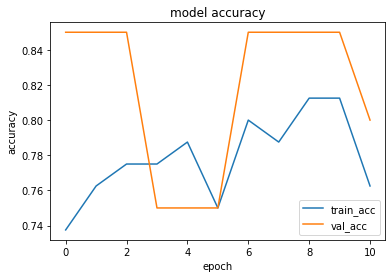

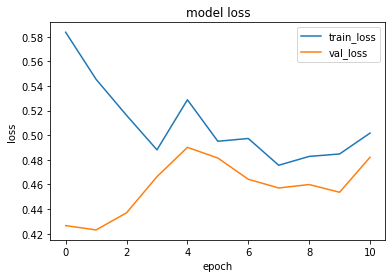

1it [00:00, 15827.56it/s]
file is another_control.mov, prediction is [[0.24095088]]
1it [00:00, 14716.86it/s]
file is short_armflapping.mov, prediction is [[0.7274129]]
1it [00:00, 15420.24it/s]
file is control_far.mov, prediction is [[0.22547495]]
1it [00:00, 14926.35it/s]
file is long_armflapping.mov, prediction is [[0.29701445]]
1it [00:00, 14027.77it/s]
file is me_reading_control.mov, prediction is [[0.22018573]]
1it [00:00, 15196.75it/s]
file is me_armflapping.mov, prediction is [[0.7647173]]
using no aug with lr 0.001
Epoch 1/50
3/3 [==============================] - 1s 310ms/step - loss: 0.6941 - accuracy: 0.5625 - val_loss: 0.6976 - val_accuracy: 0.4000
Epoch 2/50
3/3 [==============================] - 0s 152ms/step - loss: 0.6896 - accuracy: 0.5625 - val_loss: 0.6972 - val_accuracy: 0.4000
Epoch 3/50
3/3 [==============================] - 0s 172ms/step - loss: 0.6935 - accuracy: 0.5125 - val_loss: 0.6963 - val_accuracy: 0.4000
Epoch 4/50
3/3 [==============================] - 

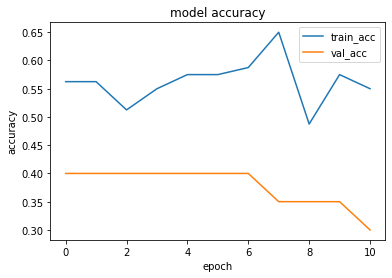

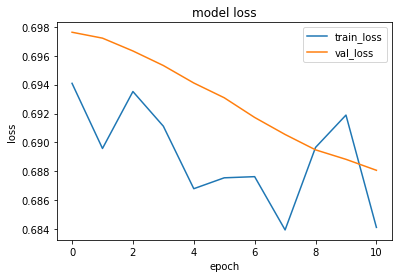

1it [00:00, 14513.16it/s]
file is another_control.mov, prediction is [[0.49478516]]
1it [00:00, 14665.40it/s]
file is short_armflapping.mov, prediction is [[0.46312144]]
1it [00:00, 14716.86it/s]
file is control_far.mov, prediction is [[0.49473506]]
1it [00:00, 14027.77it/s]
file is long_armflapping.mov, prediction is [[0.4954049]]
1it [00:00, 13357.66it/s]
file is me_reading_control.mov, prediction is [[0.49441102]]
1it [00:00, 14463.12it/s]
file is me_armflapping.mov, prediction is [[0.4895301]]
Epoch 1/50
3/3 [==============================] - 0s 175ms/step - loss: 0.6865 - accuracy: 0.5750 - val_loss: 0.6753 - val_accuracy: 0.7500
Epoch 2/50
3/3 [==============================] - 0s 137ms/step - loss: 0.6869 - accuracy: 0.5625 - val_loss: 0.6742 - val_accuracy: 0.7000
Epoch 3/50
3/3 [==============================] - 0s 145ms/step - loss: 0.6828 - accuracy: 0.6125 - val_loss: 0.6730 - val_accuracy: 0.8000
Epoch 4/50
3/3 [==============================] - 0s 152ms/step - loss: 0.681

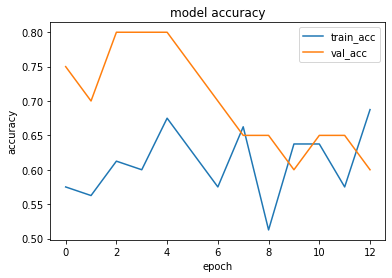

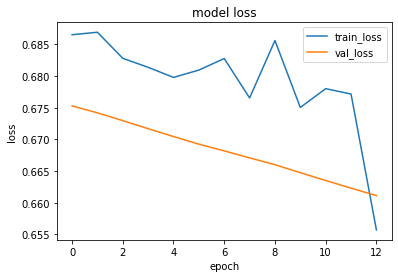

1it [00:00, 13706.88it/s]
file is another_control.mov, prediction is [[0.5013684]]
1it [00:00, 15592.21it/s]
file is short_armflapping.mov, prediction is [[0.4887758]]
1it [00:00, 18558.87it/s]
file is control_far.mov, prediction is [[0.4995508]]
1it [00:00, 17189.77it/s]
file is long_armflapping.mov, prediction is [[0.5088973]]
1it [00:00, 14665.40it/s]
file is me_reading_control.mov, prediction is [[0.49769992]]
1it [00:00, 15827.56it/s]
file is me_armflapping.mov, prediction is [[0.51715815]]
Epoch 1/50
3/3 [==============================] - 0s 152ms/step - loss: 0.6734 - accuracy: 0.6125 - val_loss: 0.6514 - val_accuracy: 0.6000
Epoch 2/50
3/3 [==============================] - 0s 133ms/step - loss: 0.6732 - accuracy: 0.5750 - val_loss: 0.6488 - val_accuracy: 0.6500
Epoch 3/50
3/3 [==============================] - 0s 140ms/step - loss: 0.6710 - accuracy: 0.5750 - val_loss: 0.6463 - val_accuracy: 0.7500
Epoch 4/50
3/3 [==============================] - 0s 134ms/step - loss: 0.6565 

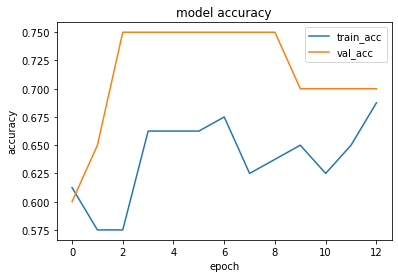

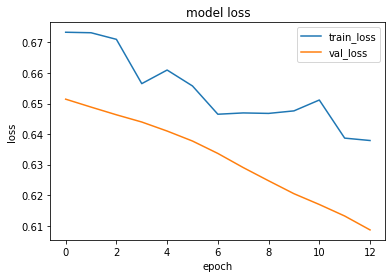

1it [00:00, 12787.51it/s]
file is another_control.mov, prediction is [[0.44668576]]
1it [00:00, 14563.56it/s]
file is short_armflapping.mov, prediction is [[0.4465324]]
1it [00:00, 14315.03it/s]
file is control_far.mov, prediction is [[0.4449392]]
1it [00:00, 14926.35it/s]
file is long_armflapping.mov, prediction is [[0.4553445]]
1it [00:00, 15420.24it/s]
file is me_reading_control.mov, prediction is [[0.44381276]]
1it [00:00, 14315.03it/s]
file is me_armflapping.mov, prediction is [[0.48229197]]
Epoch 1/50
3/3 [==============================] - 0s 164ms/step - loss: 0.6118 - accuracy: 0.7375 - val_loss: 0.6629 - val_accuracy: 0.5500
Epoch 2/50
3/3 [==============================] - 0s 137ms/step - loss: 0.6120 - accuracy: 0.7125 - val_loss: 0.6619 - val_accuracy: 0.6000
Epoch 3/50
3/3 [==============================] - 0s 125ms/step - loss: 0.6069 - accuracy: 0.7125 - val_loss: 0.6633 - val_accuracy: 0.6000
Epoch 4/50
3/3 [==============================] - 0s 135ms/step - loss: 0.6020

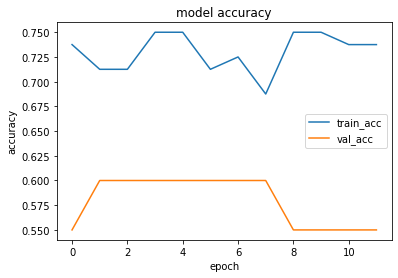

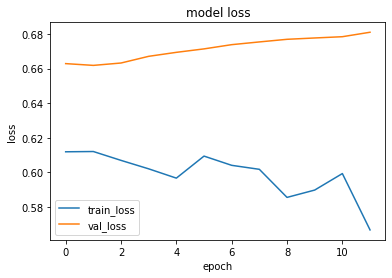

1it [00:00, 14873.42it/s]
file is another_control.mov, prediction is [[0.405179]]
1it [00:00, 17924.38it/s]
file is short_armflapping.mov, prediction is [[0.37696993]]
1it [00:00, 14315.03it/s]
file is control_far.mov, prediction is [[0.40415567]]
1it [00:00, 16912.52it/s]
file is long_armflapping.mov, prediction is [[0.41019383]]
1it [00:00, 13706.88it/s]
file is me_reading_control.mov, prediction is [[0.40319782]]
1it [00:00, 15592.21it/s]
file is me_armflapping.mov, prediction is [[0.42421746]]
Epoch 1/50
3/3 [==============================] - 0s 167ms/step - loss: 0.6125 - accuracy: 0.7125 - val_loss: 0.5887 - val_accuracy: 0.7500
Epoch 2/50
3/3 [==============================] - 0s 121ms/step - loss: 0.6054 - accuracy: 0.7000 - val_loss: 0.5882 - val_accuracy: 0.7500
Epoch 3/50
3/3 [==============================] - 0s 134ms/step - loss: 0.5957 - accuracy: 0.6875 - val_loss: 0.5885 - val_accuracy: 0.7500
Epoch 4/50
3/3 [==============================] - 0s 140ms/step - loss: 0.613

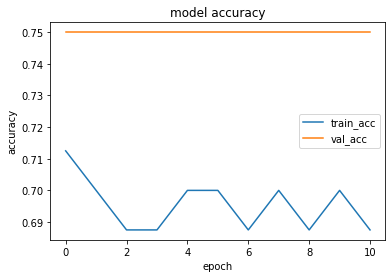

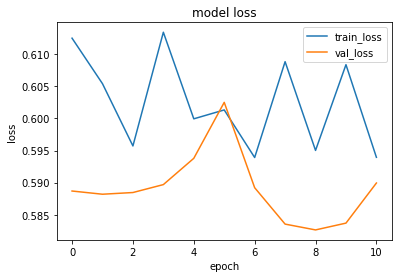

1it [00:00, 16912.52it/s]
file is another_control.mov, prediction is [[0.3914292]]
1it [00:00, 17549.39it/s]
file is short_armflapping.mov, prediction is [[0.3630983]]
1it [00:00, 14665.40it/s]
file is control_far.mov, prediction is [[0.39022157]]
1it [00:00, 14926.35it/s]
file is long_armflapping.mov, prediction is [[0.39729288]]
1it [00:00, 12372.58it/s]
file is me_reading_control.mov, prediction is [[0.38916278]]
1it [00:00, 15141.89it/s]
file is me_armflapping.mov, prediction is [[0.41570246]]
using no aug with lr 0.0005
Epoch 1/50
3/3 [==============================] - 1s 239ms/step - loss: 0.6928 - accuracy: 0.6625 - val_loss: 0.6913 - val_accuracy: 0.6000
Epoch 2/50
3/3 [==============================] - 0s 142ms/step - loss: 0.6938 - accuracy: 0.7000 - val_loss: 0.6912 - val_accuracy: 0.5500
Epoch 3/50
3/3 [==============================] - 0s 146ms/step - loss: 0.6907 - accuracy: 0.6625 - val_loss: 0.6909 - val_accuracy: 0.5500
Epoch 4/50
3/3 [==============================] -

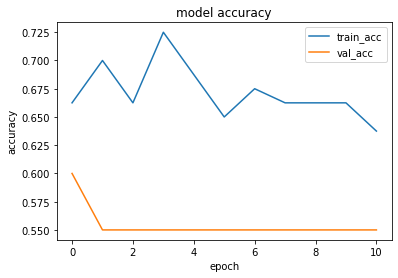

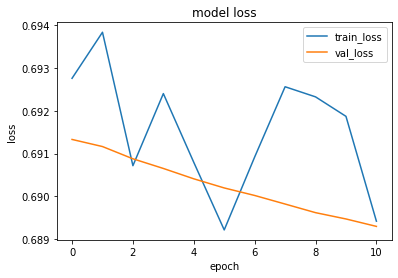

1it [00:00, 11915.64it/s]
file is another_control.mov, prediction is [[0.49531922]]
1it [00:00, 13148.29it/s]
file is short_armflapping.mov, prediction is [[0.5226828]]
1it [00:00, 14926.35it/s]
file is control_far.mov, prediction is [[0.4953293]]
1it [00:00, 16194.22it/s]
file is long_armflapping.mov, prediction is [[0.4964444]]
1it [00:00, 14716.86it/s]
file is me_reading_control.mov, prediction is [[0.49534705]]
1it [00:00, 15363.75it/s]
file is me_armflapping.mov, prediction is [[0.50016385]]
Epoch 1/50
3/3 [==============================] - 0s 160ms/step - loss: 0.6884 - accuracy: 0.6250 - val_loss: 0.6900 - val_accuracy: 0.7000
Epoch 2/50
3/3 [==============================] - 0s 133ms/step - loss: 0.6895 - accuracy: 0.6250 - val_loss: 0.6896 - val_accuracy: 0.7000
Epoch 3/50
3/3 [==============================] - 0s 143ms/step - loss: 0.6936 - accuracy: 0.6125 - val_loss: 0.6894 - val_accuracy: 0.7000
Epoch 4/50
3/3 [==============================] - 0s 131ms/step - loss: 0.6868

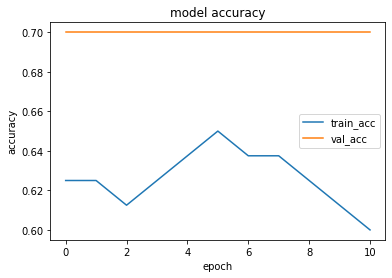

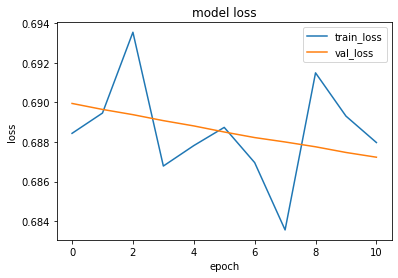

1it [00:00, 8004.40it/s]
file is another_control.mov, prediction is [[0.4928823]]
1it [00:00, 8630.26it/s]
file is short_armflapping.mov, prediction is [[0.5197163]]
1it [00:00, 14716.86it/s]
file is control_far.mov, prediction is [[0.49296072]]
1it [00:00, 15363.75it/s]
file is long_armflapping.mov, prediction is [[0.49404344]]
1it [00:00, 7516.67it/s]
file is me_reading_control.mov, prediction is [[0.49298474]]
1it [00:00, 14315.03it/s]
file is me_armflapping.mov, prediction is [[0.4976756]]
Epoch 1/50
3/3 [==============================] - 0s 159ms/step - loss: 0.6895 - accuracy: 0.6375 - val_loss: 0.6911 - val_accuracy: 0.6000
Epoch 2/50
3/3 [==============================] - 0s 136ms/step - loss: 0.6848 - accuracy: 0.6250 - val_loss: 0.6910 - val_accuracy: 0.6000
Epoch 3/50
3/3 [==============================] - 0s 136ms/step - loss: 0.6844 - accuracy: 0.6375 - val_loss: 0.6910 - val_accuracy: 0.6000
Epoch 4/50
3/3 [==============================] - 0s 137ms/step - loss: 0.6845 - 

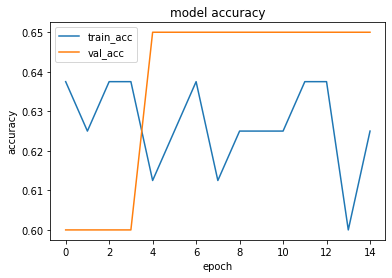

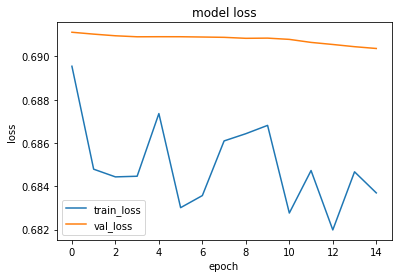

1it [00:00, 14665.40it/s]
file is another_control.mov, prediction is [[0.48791897]]
1it [00:00, 14513.16it/s]
file is short_armflapping.mov, prediction is [[0.5156952]]
1it [00:00, 17848.10it/s]
file is control_far.mov, prediction is [[0.48806408]]
1it [00:00, 17189.77it/s]
file is long_armflapping.mov, prediction is [[0.489299]]
1it [00:00, 15650.39it/s]
file is me_reading_control.mov, prediction is [[0.48810184]]
1it [00:00, 14873.42it/s]
file is me_armflapping.mov, prediction is [[0.4932353]]
Epoch 1/50
3/3 [==============================] - 0s 155ms/step - loss: 0.6815 - accuracy: 0.6125 - val_loss: 0.6888 - val_accuracy: 0.6000
Epoch 2/50
3/3 [==============================] - 0s 127ms/step - loss: 0.6828 - accuracy: 0.6250 - val_loss: 0.6888 - val_accuracy: 0.6000
Epoch 3/50
3/3 [==============================] - 0s 133ms/step - loss: 0.6835 - accuracy: 0.6250 - val_loss: 0.6888 - val_accuracy: 0.6000
Epoch 4/50
3/3 [==============================] - 0s 126ms/step - loss: 0.6835 

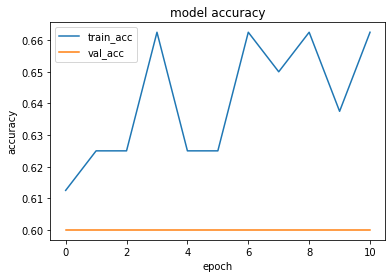

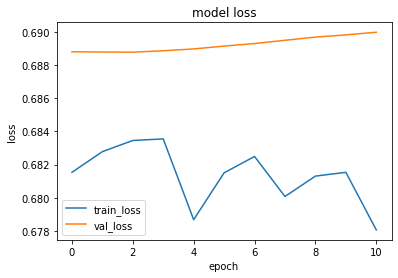

1it [00:00, 17260.51it/s]
file is another_control.mov, prediction is [[0.4890922]]
1it [00:00, 14716.86it/s]
file is short_armflapping.mov, prediction is [[0.51806283]]
1it [00:00, 15363.75it/s]
file is control_far.mov, prediction is [[0.48925322]]
1it [00:00, 14926.35it/s]
file is long_armflapping.mov, prediction is [[0.49081892]]
1it [00:00, 15887.52it/s]
file is me_reading_control.mov, prediction is [[0.48930392]]
1it [00:00, 15141.89it/s]
file is me_armflapping.mov, prediction is [[0.49524814]]
Epoch 1/50
3/3 [==============================] - 0s 155ms/step - loss: 0.6825 - accuracy: 0.6125 - val_loss: 0.6744 - val_accuracy: 0.7000
Epoch 2/50
3/3 [==============================] - 0s 126ms/step - loss: 0.6817 - accuracy: 0.6125 - val_loss: 0.6741 - val_accuracy: 0.7000
Epoch 3/50
3/3 [==============================] - 0s 133ms/step - loss: 0.6814 - accuracy: 0.6250 - val_loss: 0.6738 - val_accuracy: 0.7500
Epoch 4/50
3/3 [==============================] - 0s 130ms/step - loss: 0.68

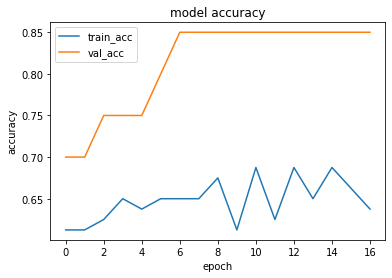

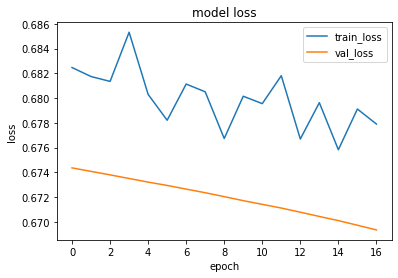

1it [00:00, 14463.12it/s]
file is another_control.mov, prediction is [[0.49281275]]
1it [00:00, 10512.04it/s]
file is short_armflapping.mov, prediction is [[0.5248646]]
1it [00:00, 13888.42it/s]
file is control_far.mov, prediction is [[0.4928972]]
1it [00:00, 14463.12it/s]
file is long_armflapping.mov, prediction is [[0.4952575]]
1it [00:00, 14768.68it/s]
file is me_reading_control.mov, prediction is [[0.49295935]]
1it [00:00, 14926.35it/s]
file is me_armflapping.mov, prediction is [[0.5002853]]
using no aug with lr 0.0001
Epoch 1/50
3/3 [==============================] - 1s 222ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6873 - val_accuracy: 0.5000
Epoch 2/50
3/3 [==============================] - 0s 148ms/step - loss: 0.6941 - accuracy: 0.5750 - val_loss: 0.6871 - val_accuracy: 0.5000
Epoch 3/50
3/3 [==============================] - 0s 126ms/step - loss: 0.6918 - accuracy: 0.5375 - val_loss: 0.6870 - val_accuracy: 0.5000
Epoch 4/50
3/3 [==============================] - 0

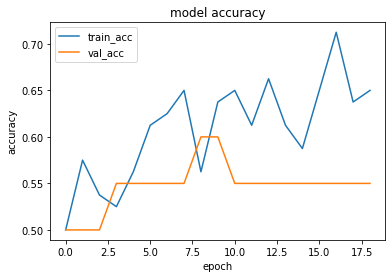

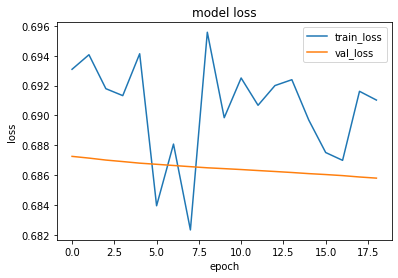

1it [00:00, 4604.07it/s]
file is another_control.mov, prediction is [[0.49756554]]
1it [00:00, 18558.87it/s]
file is short_armflapping.mov, prediction is [[0.49915457]]
1it [00:00, 12192.74it/s]
file is control_far.mov, prediction is [[0.49754277]]
1it [00:00, 17549.39it/s]
file is long_armflapping.mov, prediction is [[0.4982747]]
1it [00:00, 14665.40it/s]
file is me_reading_control.mov, prediction is [[0.4975336]]
1it [00:00, 16070.13it/s]
file is me_armflapping.mov, prediction is [[0.5024579]]
Epoch 1/50
3/3 [==============================] - 0s 150ms/step - loss: 0.6913 - accuracy: 0.5375 - val_loss: 0.6875 - val_accuracy: 0.7000
Epoch 2/50
3/3 [==============================] - 0s 131ms/step - loss: 0.6955 - accuracy: 0.5625 - val_loss: 0.6874 - val_accuracy: 0.7000
Epoch 3/50
3/3 [==============================] - 0s 133ms/step - loss: 0.6873 - accuracy: 0.5750 - val_loss: 0.6872 - val_accuracy: 0.7000
Epoch 4/50
3/3 [==============================] - 1s 200ms/step - loss: 0.6878 

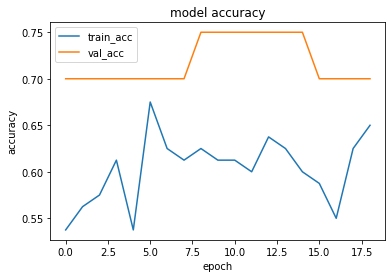

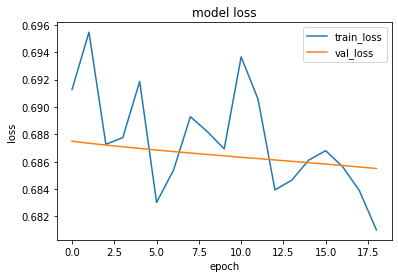

1it [00:00, 18477.11it/s]
file is another_control.mov, prediction is [[0.49785078]]
1it [00:00, 16384.00it/s]
file is short_armflapping.mov, prediction is [[0.49974167]]
1it [00:00, 17260.51it/s]
file is control_far.mov, prediction is [[0.49769053]]
1it [00:00, 14266.34it/s]
file is long_armflapping.mov, prediction is [[0.49889538]]
1it [00:00, 15887.52it/s]
file is me_reading_control.mov, prediction is [[0.49766847]]
1it [00:00, 18641.35it/s]
file is me_armflapping.mov, prediction is [[0.5033421]]
Epoch 1/50
3/3 [==============================] - 0s 158ms/step - loss: 0.6845 - accuracy: 0.6250 - val_loss: 0.6882 - val_accuracy: 0.5500
Epoch 2/50
3/3 [==============================] - 0s 118ms/step - loss: 0.6924 - accuracy: 0.6000 - val_loss: 0.6880 - val_accuracy: 0.5500
Epoch 3/50
3/3 [==============================] - 0s 140ms/step - loss: 0.6826 - accuracy: 0.6250 - val_loss: 0.6880 - val_accuracy: 0.5500
Epoch 4/50
3/3 [==============================] - 0s 133ms/step - loss: 0.68

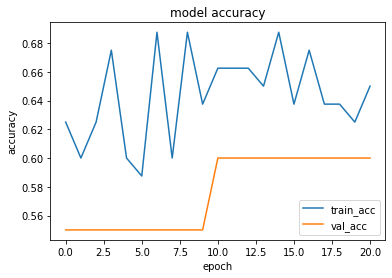

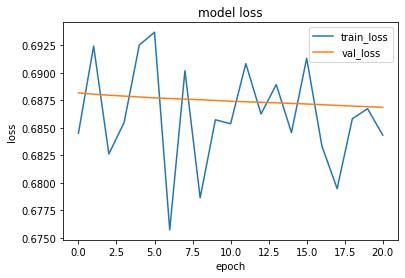

1it [00:00, 12520.31it/s]
file is another_control.mov, prediction is [[0.4961631]]
1it [00:00, 14513.16it/s]
file is short_armflapping.mov, prediction is [[0.49845973]]
1it [00:00, 14665.40it/s]
file is control_far.mov, prediction is [[0.49585244]]
1it [00:00, 15420.24it/s]
file is long_armflapping.mov, prediction is [[0.49757597]]
1it [00:00, 17476.27it/s]
file is me_reading_control.mov, prediction is [[0.4958149]]
1it [00:00, 13934.56it/s]
file is me_armflapping.mov, prediction is [[0.50233704]]
Epoch 1/50
3/3 [==============================] - 0s 157ms/step - loss: 0.6826 - accuracy: 0.6375 - val_loss: 0.6987 - val_accuracy: 0.6000
Epoch 2/50
3/3 [==============================] - 0s 121ms/step - loss: 0.6803 - accuracy: 0.6500 - val_loss: 0.6987 - val_accuracy: 0.6000
Epoch 3/50
3/3 [==============================] - 0s 135ms/step - loss: 0.6830 - accuracy: 0.6250 - val_loss: 0.6987 - val_accuracy: 0.6000
Epoch 4/50
3/3 [==============================] - 0s 130ms/step - loss: 0.679

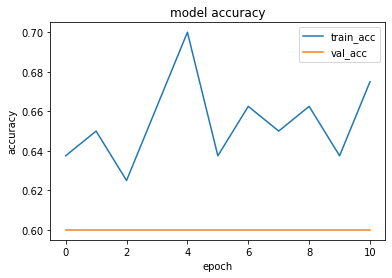

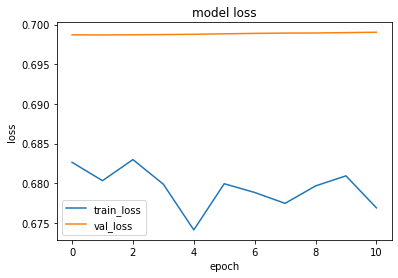

1it [00:00, 13706.88it/s]
file is another_control.mov, prediction is [[0.4970838]]
1it [00:00, 13888.42it/s]
file is short_armflapping.mov, prediction is [[0.49974984]]
1it [00:00, 14463.12it/s]
file is control_far.mov, prediction is [[0.49665478]]
1it [00:00, 15196.75it/s]
file is long_armflapping.mov, prediction is [[0.4987821]]
1it [00:00, 14979.66it/s]
file is me_reading_control.mov, prediction is [[0.4966017]]
1it [00:00, 16070.13it/s]
file is me_armflapping.mov, prediction is [[0.5038952]]
Epoch 1/50
3/3 [==============================] - 0s 159ms/step - loss: 0.6901 - accuracy: 0.5625 - val_loss: 0.6742 - val_accuracy: 0.8500
Epoch 2/50
3/3 [==============================] - 0s 127ms/step - loss: 0.6884 - accuracy: 0.6000 - val_loss: 0.6741 - val_accuracy: 0.8500
Epoch 3/50
3/3 [==============================] - 0s 133ms/step - loss: 0.6807 - accuracy: 0.6375 - val_loss: 0.6740 - val_accuracy: 0.8500
Epoch 4/50
3/3 [==============================] - 0s 123ms/step - loss: 0.6881 

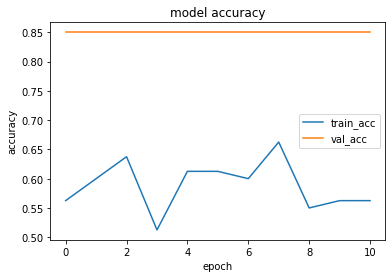

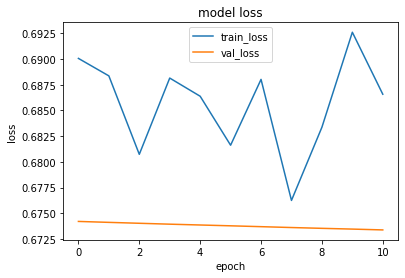

1it [00:00, 14926.35it/s]
file is another_control.mov, prediction is [[0.4974887]]
1it [00:00, 17260.51it/s]
file is short_armflapping.mov, prediction is [[0.50039726]]
1it [00:00, 14217.98it/s]
file is control_far.mov, prediction is [[0.49698067]]
1it [00:00, 14716.86it/s]
file is long_armflapping.mov, prediction is [[0.49939257]]
1it [00:00, 18893.26it/s]
file is me_reading_control.mov, prediction is [[0.49691534]]
1it [00:00, 15141.89it/s]
file is me_armflapping.mov, prediction is [[0.50470245]]
using aug with lr 0.01
Epoch 1/50
3/3 [==============================] - 1s 245ms/step - loss: 0.6883 - accuracy: 0.6125 - val_loss: 0.6732 - val_accuracy: 0.6500
Epoch 2/50
3/3 [==============================] - 0s 130ms/step - loss: 0.6887 - accuracy: 0.5875 - val_loss: 0.6747 - val_accuracy: 0.6000
Epoch 3/50
3/3 [==============================] - 0s 130ms/step - loss: 0.6726 - accuracy: 0.6250 - val_loss: 0.6750 - val_accuracy: 0.5000
Epoch 4/50
3/3 [==============================] - 0s 

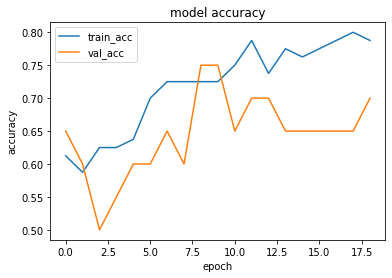

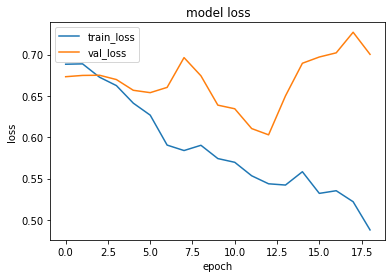

1it [00:00, 15420.24it/s]
file is another_control.mov, prediction is [[0.18815759]]
1it [00:00, 16644.06it/s]
file is short_armflapping.mov, prediction is [[0.6135834]]
1it [00:00, 15141.89it/s]
file is control_far.mov, prediction is [[0.13129863]]
1it [00:00, 3358.13it/s]
file is long_armflapping.mov, prediction is [[0.54674274]]
1it [00:00, 1322.71it/s]
file is me_reading_control.mov, prediction is [[0.16263875]]
1it [00:00, 16912.52it/s]
file is me_armflapping.mov, prediction is [[0.706584]]
Epoch 1/50
3/3 [==============================] - 1s 175ms/step - loss: 0.5584 - accuracy: 0.7375 - val_loss: 0.5113 - val_accuracy: 0.7500
Epoch 2/50
3/3 [==============================] - 0s 133ms/step - loss: 0.5836 - accuracy: 0.7500 - val_loss: 0.5011 - val_accuracy: 0.7500
Epoch 3/50
3/3 [==============================] - 1s 390ms/step - loss: 0.5304 - accuracy: 0.7375 - val_loss: 0.4947 - val_accuracy: 0.8000
Epoch 4/50
3/3 [==============================] - 0s 147ms/step - loss: 0.5221 -

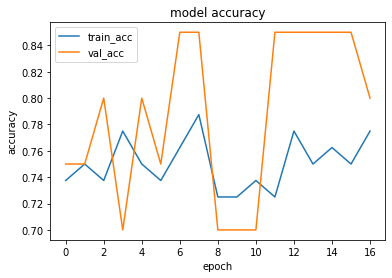

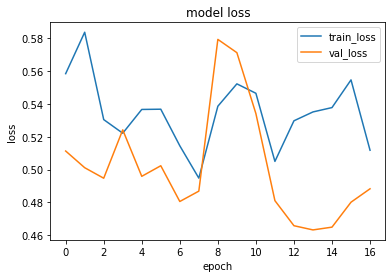

1it [00:00, 12520.31it/s]
file is another_control.mov, prediction is [[0.40545458]]
1it [00:00, 7194.35it/s]
file is short_armflapping.mov, prediction is [[0.69350415]]
1it [00:00, 16980.99it/s]
file is control_far.mov, prediction is [[0.34726948]]
1it [00:00, 8924.05it/s]
file is long_armflapping.mov, prediction is [[0.5681882]]
1it [00:00, 14716.86it/s]
file is me_reading_control.mov, prediction is [[0.30749813]]
1it [00:00, 13025.79it/s]
file is me_armflapping.mov, prediction is [[0.73270124]]
Epoch 1/50
3/3 [==============================] - 0s 172ms/step - loss: 0.5286 - accuracy: 0.7625 - val_loss: 0.5048 - val_accuracy: 0.8000
Epoch 2/50
3/3 [==============================] - 0s 144ms/step - loss: 0.5118 - accuracy: 0.7500 - val_loss: 0.5319 - val_accuracy: 0.8000
Epoch 3/50
3/3 [==============================] - 0s 138ms/step - loss: 0.5026 - accuracy: 0.7625 - val_loss: 0.5333 - val_accuracy: 0.8000
Epoch 4/50
3/3 [==============================] - 0s 137ms/step - loss: 0.5056

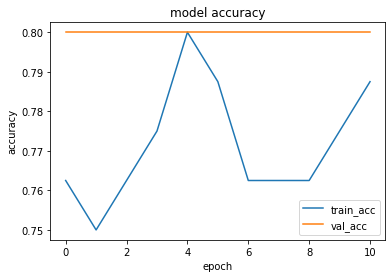

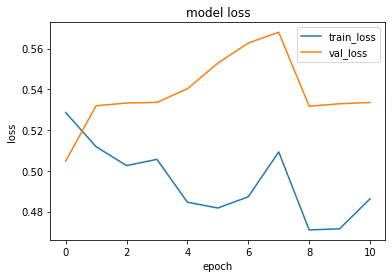

1it [00:00, 4650.00it/s]
file is another_control.mov, prediction is [[0.40747657]]
1it [00:00, 14768.68it/s]
file is short_armflapping.mov, prediction is [[0.61667883]]
1it [00:00, 18477.11it/s]
file is control_far.mov, prediction is [[0.28848255]]
1it [00:00, 12372.58it/s]
file is long_armflapping.mov, prediction is [[0.4885046]]
1it [00:00, 14926.35it/s]
file is me_reading_control.mov, prediction is [[0.34530646]]
1it [00:00, 15363.75it/s]
file is me_armflapping.mov, prediction is [[0.7138676]]
Epoch 1/50
3/3 [==============================] - 1s 328ms/step - loss: 0.4864 - accuracy: 0.8125 - val_loss: 0.3661 - val_accuracy: 0.8500
Epoch 2/50
3/3 [==============================] - 0s 145ms/step - loss: 0.4931 - accuracy: 0.7750 - val_loss: 0.3548 - val_accuracy: 0.8500
Epoch 3/50
3/3 [==============================] - 0s 153ms/step - loss: 0.5040 - accuracy: 0.7625 - val_loss: 0.3636 - val_accuracy: 0.8500
Epoch 4/50
3/3 [==============================] - 0s 144ms/step - loss: 0.6568

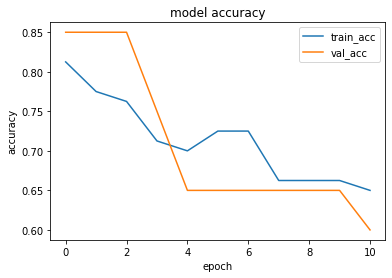

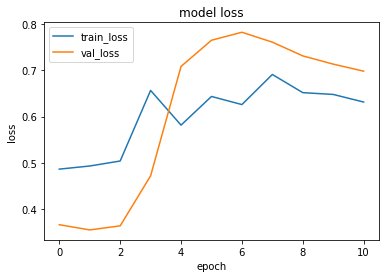

1it [00:00, 13662.23it/s]
file is another_control.mov, prediction is [[0.39778087]]
1it [00:00, 17549.39it/s]
file is short_armflapping.mov, prediction is [[0.48607817]]
1it [00:00, 17549.39it/s]
file is control_far.mov, prediction is [[0.3443222]]
1it [00:00, 16070.13it/s]
file is long_armflapping.mov, prediction is [[0.4782353]]
1it [00:00, 17848.10it/s]
file is me_reading_control.mov, prediction is [[0.34761953]]
1it [00:00, 18157.16it/s]
file is me_armflapping.mov, prediction is [[0.53720266]]
Epoch 1/50
3/3 [==============================] - 0s 157ms/step - loss: 0.6867 - accuracy: 0.6125 - val_loss: 0.5334 - val_accuracy: 0.8000
Epoch 2/50
3/3 [==============================] - 0s 122ms/step - loss: 0.6478 - accuracy: 0.6125 - val_loss: 0.5267 - val_accuracy: 0.8500
Epoch 3/50
3/3 [==============================] - 0s 154ms/step - loss: 0.6389 - accuracy: 0.6625 - val_loss: 0.5234 - val_accuracy: 0.8500
Epoch 4/50
3/3 [==============================] - 0s 124ms/step - loss: 0.644

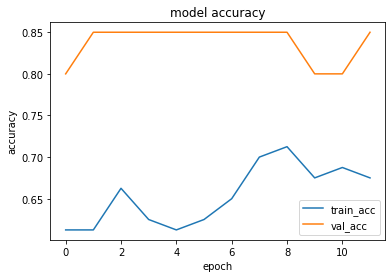

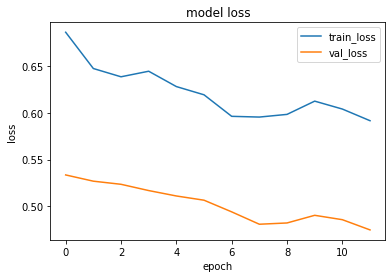

1it [00:00, 18558.87it/s]
file is another_control.mov, prediction is [[0.3929143]]
1it [00:00, 12985.46it/s]
file is short_armflapping.mov, prediction is [[0.5433426]]
1it [00:00, 17260.51it/s]
file is control_far.mov, prediction is [[0.301462]]
1it [00:00, 14665.40it/s]
file is long_armflapping.mov, prediction is [[0.5270752]]
1it [00:00, 17848.10it/s]
file is me_reading_control.mov, prediction is [[0.24807909]]
1it [00:00, 15768.06it/s]
file is me_armflapping.mov, prediction is [[0.60200846]]
using aug with lr 0.001
Epoch 1/50
3/3 [==============================] - 1s 249ms/step - loss: 0.6934 - accuracy: 0.6000 - val_loss: 0.6809 - val_accuracy: 0.6500
Epoch 2/50
3/3 [==============================] - 1s 231ms/step - loss: 0.6925 - accuracy: 0.6250 - val_loss: 0.6804 - val_accuracy: 0.6500
Epoch 3/50
3/3 [==============================] - 0s 133ms/step - loss: 0.6941 - accuracy: 0.6125 - val_loss: 0.6798 - val_accuracy: 0.7000
Epoch 4/50
3/3 [==============================] - 0s 136

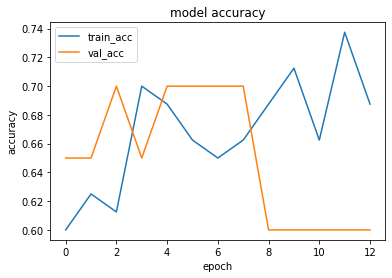

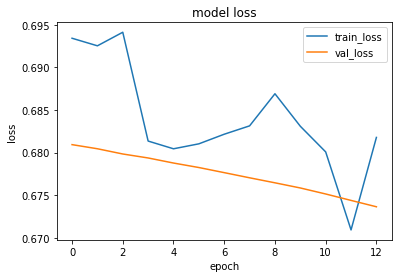

1it [00:00, 12787.51it/s]
file is another_control.mov, prediction is [[0.4836441]]
1it [00:00, 14665.40it/s]
file is short_armflapping.mov, prediction is [[0.4970025]]
1it [00:00, 18157.16it/s]
file is control_far.mov, prediction is [[0.481005]]
1it [00:00, 16980.99it/s]
file is long_armflapping.mov, prediction is [[0.49056745]]
1it [00:00, 17189.77it/s]
file is me_reading_control.mov, prediction is [[0.47935742]]
1it [00:00, 17549.39it/s]
file is me_armflapping.mov, prediction is [[0.50499487]]
Epoch 1/50
3/3 [==============================] - 0s 149ms/step - loss: 0.6773 - accuracy: 0.6750 - val_loss: 0.6670 - val_accuracy: 0.7500
Epoch 2/50
3/3 [==============================] - 0s 140ms/step - loss: 0.6765 - accuracy: 0.6500 - val_loss: 0.6651 - val_accuracy: 0.7500
Epoch 3/50
3/3 [==============================] - 0s 132ms/step - loss: 0.6777 - accuracy: 0.6750 - val_loss: 0.6631 - val_accuracy: 0.7500
Epoch 4/50
3/3 [==============================] - 0s 138ms/step - loss: 0.6627 

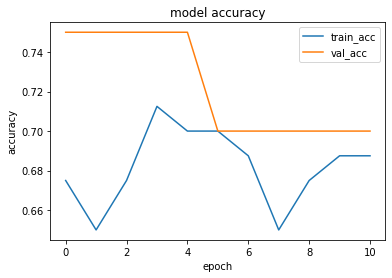

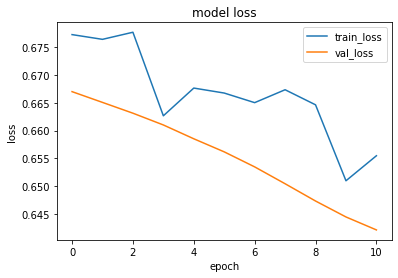

1it [00:00, 8612.53it/s]
file is another_control.mov, prediction is [[0.46215996]]
1it [00:00, 15141.89it/s]
file is short_armflapping.mov, prediction is [[0.5101297]]
1it [00:00, 6668.21it/s]
file is control_far.mov, prediction is [[0.45671463]]
1it [00:00, 16320.25it/s]
file is long_armflapping.mov, prediction is [[0.48283592]]
1it [00:00, 12157.40it/s]
file is me_reading_control.mov, prediction is [[0.45374784]]
1it [00:00, 14266.34it/s]
file is me_armflapping.mov, prediction is [[0.5347599]]
Epoch 1/50
3/3 [==============================] - 0s 145ms/step - loss: 0.6441 - accuracy: 0.7125 - val_loss: 0.6420 - val_accuracy: 0.7000
Epoch 2/50
3/3 [==============================] - 0s 140ms/step - loss: 0.6509 - accuracy: 0.6625 - val_loss: 0.6370 - val_accuracy: 0.7000
Epoch 3/50
3/3 [==============================] - 1s 208ms/step - loss: 0.6398 - accuracy: 0.6750 - val_loss: 0.6325 - val_accuracy: 0.7000
Epoch 4/50
3/3 [==============================] - 0s 132ms/step - loss: 0.6298 

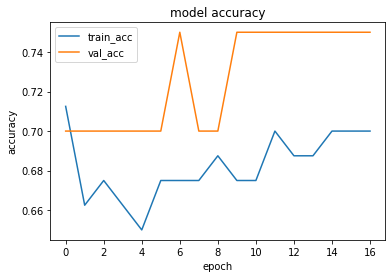

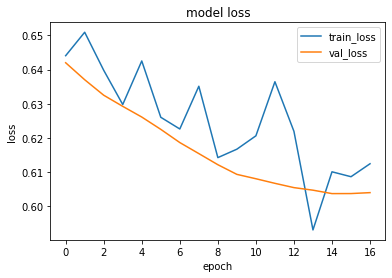

1it [00:00, 13888.42it/s]
file is another_control.mov, prediction is [[0.30789247]]
1it [00:00, 15827.56it/s]
file is short_armflapping.mov, prediction is [[0.478218]]
1it [00:00, 13148.29it/s]
file is control_far.mov, prediction is [[0.29838306]]
1it [00:00, 18157.16it/s]
file is long_armflapping.mov, prediction is [[0.3528144]]
1it [00:00, 18558.87it/s]
file is me_reading_control.mov, prediction is [[0.31159338]]
1it [00:00, 17848.10it/s]
file is me_armflapping.mov, prediction is [[0.52709377]]
Epoch 1/50
3/3 [==============================] - 0s 149ms/step - loss: 0.5918 - accuracy: 0.7375 - val_loss: 0.6486 - val_accuracy: 0.6000
Epoch 2/50
3/3 [==============================] - 0s 135ms/step - loss: 0.6046 - accuracy: 0.7250 - val_loss: 0.6491 - val_accuracy: 0.6000
Epoch 3/50
3/3 [==============================] - 0s 132ms/step - loss: 0.5888 - accuracy: 0.7125 - val_loss: 0.6488 - val_accuracy: 0.6000
Epoch 4/50
3/3 [==============================] - 0s 123ms/step - loss: 0.5896

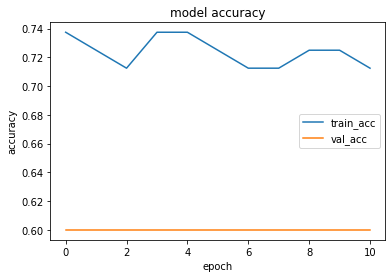

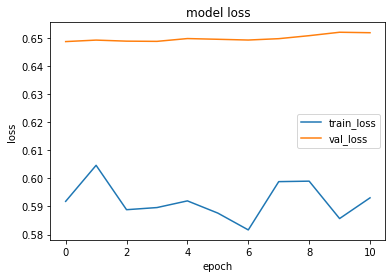

1it [00:00, 9157.87it/s]
file is another_control.mov, prediction is [[0.27719796]]
1it [00:00, 18157.16it/s]
file is short_armflapping.mov, prediction is [[0.49584085]]
1it [00:00, 13315.25it/s]
file is control_far.mov, prediction is [[0.267453]]
1it [00:00, 18893.26it/s]
file is long_armflapping.mov, prediction is [[0.32874736]]
1it [00:00, 18558.87it/s]
file is me_reading_control.mov, prediction is [[0.27957642]]
1it [00:00, 18893.26it/s]
file is me_armflapping.mov, prediction is [[0.56051034]]
Epoch 1/50
3/3 [==============================] - 1s 218ms/step - loss: 0.5995 - accuracy: 0.6750 - val_loss: 0.5370 - val_accuracy: 0.8000
Epoch 2/50
3/3 [==============================] - 0s 136ms/step - loss: 0.6095 - accuracy: 0.6875 - val_loss: 0.5393 - val_accuracy: 0.8000
Epoch 3/50
3/3 [==============================] - 0s 139ms/step - loss: 0.5939 - accuracy: 0.6750 - val_loss: 0.5418 - val_accuracy: 0.8000
Epoch 4/50
3/3 [==============================] - 0s 132ms/step - loss: 0.6101

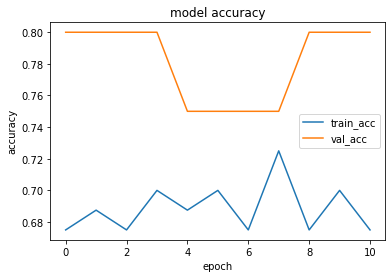

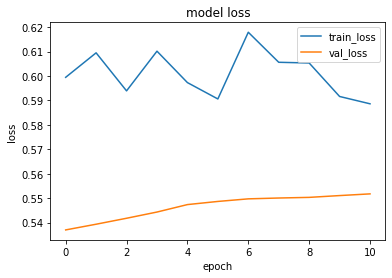

1it [00:00, 14122.24it/s]
file is another_control.mov, prediction is [[0.3030667]]
1it [00:00, 11125.47it/s]
file is short_armflapping.mov, prediction is [[0.48345408]]
1it [00:00, 10538.45it/s]
file is control_far.mov, prediction is [[0.29031414]]
1it [00:00, 14513.16it/s]
file is long_armflapping.mov, prediction is [[0.36731339]]
1it [00:00, 15650.39it/s]
file is me_reading_control.mov, prediction is [[0.29318035]]
1it [00:00, 17924.38it/s]
file is me_armflapping.mov, prediction is [[0.5642119]]
using aug with lr 0.0005
Epoch 1/50
3/3 [==============================] - 1s 215ms/step - loss: 0.6927 - accuracy: 0.6125 - val_loss: 0.6922 - val_accuracy: 0.5000
Epoch 2/50
3/3 [==============================] - 0s 136ms/step - loss: 0.6894 - accuracy: 0.6875 - val_loss: 0.6916 - val_accuracy: 0.4500
Epoch 3/50
3/3 [==============================] - 0s 136ms/step - loss: 0.6904 - accuracy: 0.6750 - val_loss: 0.6909 - val_accuracy: 0.4500
Epoch 4/50
3/3 [==============================] - 0s

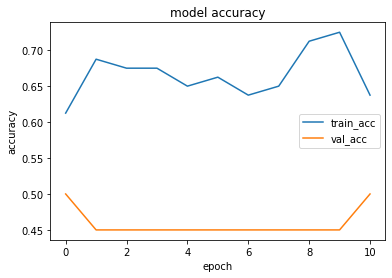

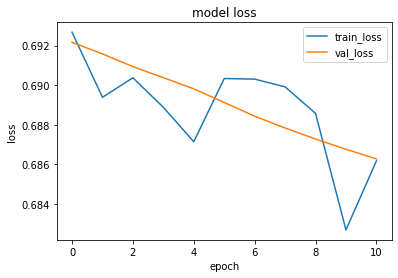

1it [00:00, 10754.63it/s]
file is another_control.mov, prediction is [[0.49448174]]
1it [00:00, 16448.25it/s]
file is short_armflapping.mov, prediction is [[0.50669086]]
1it [00:00, 17260.51it/s]
file is control_far.mov, prediction is [[0.4949233]]
1it [00:00, 16384.00it/s]
file is long_armflapping.mov, prediction is [[0.494796]]
1it [00:00, 14873.42it/s]
file is me_reading_control.mov, prediction is [[0.4946971]]
1it [00:00, 17848.10it/s]
file is me_armflapping.mov, prediction is [[0.4906334]]
Epoch 1/50
3/3 [==============================] - 0s 160ms/step - loss: 0.6889 - accuracy: 0.5750 - val_loss: 0.6847 - val_accuracy: 0.7500
Epoch 2/50
3/3 [==============================] - 0s 126ms/step - loss: 0.6840 - accuracy: 0.5875 - val_loss: 0.6842 - val_accuracy: 0.7500
Epoch 3/50
3/3 [==============================] - 0s 126ms/step - loss: 0.6817 - accuracy: 0.6125 - val_loss: 0.6836 - val_accuracy: 0.7500
Epoch 4/50
3/3 [==============================] - 0s 195ms/step - loss: 0.6860 -

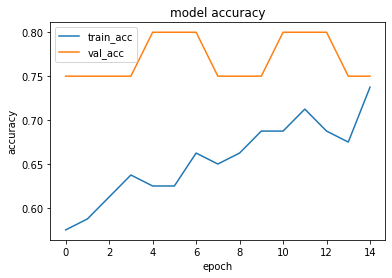

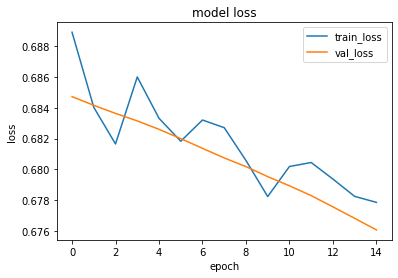

1it [00:00, 13357.66it/s]
file is another_control.mov, prediction is [[0.4980437]]
1it [00:00, 14217.98it/s]
file is short_armflapping.mov, prediction is [[0.51336324]]
1it [00:00, 16194.22it/s]
file is control_far.mov, prediction is [[0.49817425]]
1it [00:00, 15887.52it/s]
file is long_armflapping.mov, prediction is [[0.49952662]]
1it [00:00, 17623.13it/s]
file is me_reading_control.mov, prediction is [[0.49770847]]
1it [00:00, 18236.10it/s]
file is me_armflapping.mov, prediction is [[0.4981097]]
Epoch 1/50
3/3 [==============================] - 0s 160ms/step - loss: 0.6692 - accuracy: 0.7625 - val_loss: 0.6784 - val_accuracy: 0.7500
Epoch 2/50
3/3 [==============================] - 0s 132ms/step - loss: 0.6713 - accuracy: 0.7500 - val_loss: 0.6772 - val_accuracy: 0.7500
Epoch 3/50
3/3 [==============================] - 0s 126ms/step - loss: 0.6775 - accuracy: 0.6750 - val_loss: 0.6761 - val_accuracy: 0.8000
Epoch 4/50
3/3 [==============================] - 0s 129ms/step - loss: 0.669

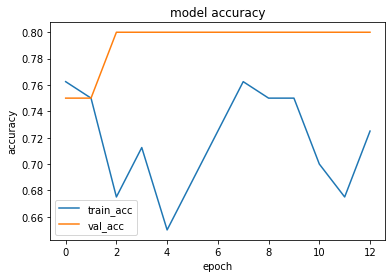

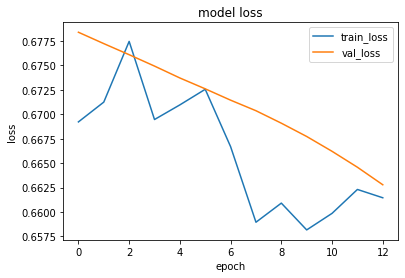

1it [00:00, 10205.12it/s]
file is another_control.mov, prediction is [[0.4969839]]
1it [00:00, 14513.16it/s]
file is short_armflapping.mov, prediction is [[0.5190592]]
1it [00:00, 15650.39it/s]
file is control_far.mov, prediction is [[0.49691412]]
1it [00:00, 18157.16it/s]
file is long_armflapping.mov, prediction is [[0.5005097]]
1it [00:00, 18157.16it/s]
file is me_reading_control.mov, prediction is [[0.49569613]]
1it [00:00, 14463.12it/s]
file is me_armflapping.mov, prediction is [[0.504305]]
Epoch 1/50
3/3 [==============================] - 0s 155ms/step - loss: 0.6454 - accuracy: 0.7500 - val_loss: 0.6721 - val_accuracy: 0.7000
Epoch 2/50
3/3 [==============================] - 0s 119ms/step - loss: 0.6509 - accuracy: 0.7500 - val_loss: 0.6716 - val_accuracy: 0.6500
Epoch 3/50
3/3 [==============================] - 0s 187ms/step - loss: 0.6455 - accuracy: 0.7375 - val_loss: 0.6713 - val_accuracy: 0.6500
Epoch 4/50
3/3 [==============================] - 0s 129ms/step - loss: 0.6434 -

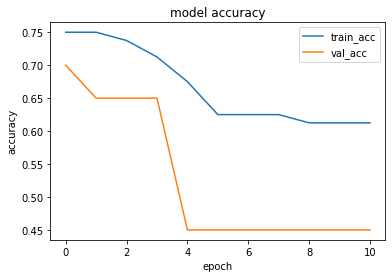

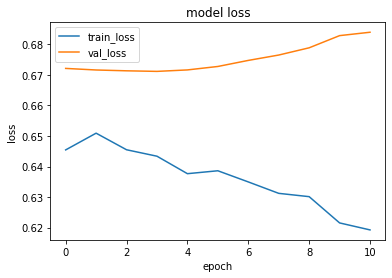

1it [00:00, 17260.51it/s]
file is another_control.mov, prediction is [[0.5175716]]
1it [00:00, 15363.75it/s]
file is short_armflapping.mov, prediction is [[0.5595973]]
1it [00:00, 18315.74it/s]
file is control_far.mov, prediction is [[0.516405]]
1it [00:00, 18477.11it/s]
file is long_armflapping.mov, prediction is [[0.5274538]]
1it [00:00, 17848.10it/s]
file is me_reading_control.mov, prediction is [[0.51287055]]
1it [00:00, 17189.77it/s]
file is me_armflapping.mov, prediction is [[0.54733896]]
Epoch 1/50
3/3 [==============================] - 0s 156ms/step - loss: 0.6353 - accuracy: 0.6000 - val_loss: 0.6351 - val_accuracy: 0.5000
Epoch 2/50
3/3 [==============================] - 0s 129ms/step - loss: 0.6262 - accuracy: 0.6000 - val_loss: 0.6353 - val_accuracy: 0.5000
Epoch 3/50
3/3 [==============================] - 0s 135ms/step - loss: 0.6329 - accuracy: 0.6000 - val_loss: 0.6355 - val_accuracy: 0.5000
Epoch 4/50
3/3 [==============================] - 0s 134ms/step - loss: 0.6365 -

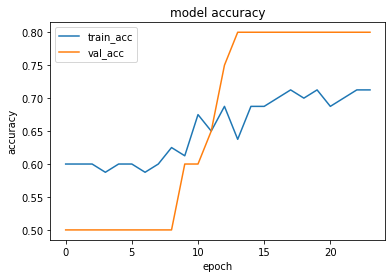

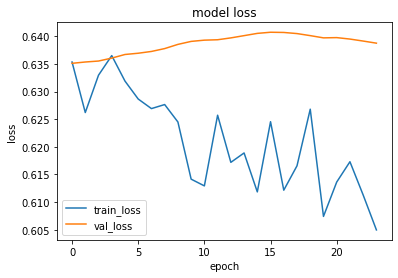

1it [00:00, 15363.75it/s]
file is another_control.mov, prediction is [[0.4928745]]
1it [00:00, 17260.51it/s]
file is short_armflapping.mov, prediction is [[0.5593548]]
1it [00:00, 16131.94it/s]
file is control_far.mov, prediction is [[0.4922847]]
1it [00:00, 15768.06it/s]
file is long_armflapping.mov, prediction is [[0.512696]]
1it [00:00, 14873.42it/s]
file is me_reading_control.mov, prediction is [[0.4829442]]
1it [00:00, 10230.01it/s]
file is me_armflapping.mov, prediction is [[0.5586125]]
using aug with lr 0.0001
Epoch 1/50
3/3 [==============================] - 1s 211ms/step - loss: 0.6911 - accuracy: 0.5750 - val_loss: 0.6878 - val_accuracy: 0.5500
Epoch 2/50
3/3 [==============================] - 0s 133ms/step - loss: 0.6943 - accuracy: 0.6000 - val_loss: 0.6878 - val_accuracy: 0.5500
Epoch 3/50
3/3 [==============================] - 0s 121ms/step - loss: 0.6908 - accuracy: 0.6625 - val_loss: 0.6878 - val_accuracy: 0.5500
Epoch 4/50
3/3 [==============================] - 0s 129m

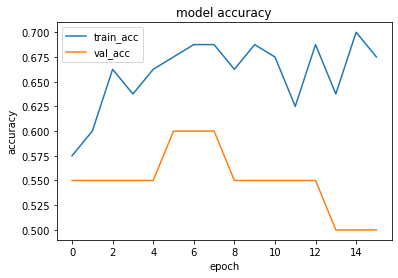

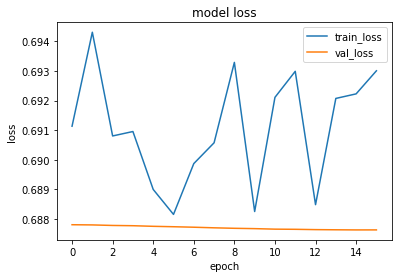

1it [00:00, 11748.75it/s]
file is another_control.mov, prediction is [[0.49937734]]
1it [00:00, 10205.12it/s]
file is short_armflapping.mov, prediction is [[0.51912755]]
1it [00:00, 5745.62it/s]
file is control_far.mov, prediction is [[0.4987293]]
1it [00:00, 16710.37it/s]
file is long_armflapping.mov, prediction is [[0.5016585]]
1it [00:00, 17848.10it/s]
file is me_reading_control.mov, prediction is [[0.4986291]]
1it [00:00, 17623.13it/s]
file is me_armflapping.mov, prediction is [[0.5157616]]
Epoch 1/50
3/3 [==============================] - 0s 164ms/step - loss: 0.6920 - accuracy: 0.6250 - val_loss: 0.6900 - val_accuracy: 0.7500
Epoch 2/50
3/3 [==============================] - 0s 123ms/step - loss: 0.6893 - accuracy: 0.6625 - val_loss: 0.6899 - val_accuracy: 0.7500
Epoch 3/50
3/3 [==============================] - 0s 129ms/step - loss: 0.6932 - accuracy: 0.6125 - val_loss: 0.6899 - val_accuracy: 0.7500
Epoch 4/50
3/3 [==============================] - 0s 133ms/step - loss: 0.6913 -

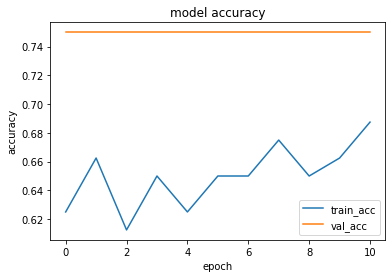

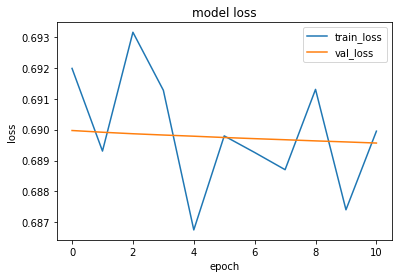

1it [00:00, 9020.01it/s]
file is another_control.mov, prediction is [[0.4993076]]
1it [00:00, 14768.68it/s]
file is short_armflapping.mov, prediction is [[0.51919997]]
1it [00:00, 14074.85it/s]
file is control_far.mov, prediction is [[0.4986208]]
1it [00:00, 18315.74it/s]
file is long_armflapping.mov, prediction is [[0.50169086]]
1it [00:00, 17848.10it/s]
file is me_reading_control.mov, prediction is [[0.49850762]]
1it [00:00, 17924.38it/s]
file is me_armflapping.mov, prediction is [[0.51600116]]
Epoch 1/50
3/3 [==============================] - 0s 160ms/step - loss: 0.6879 - accuracy: 0.6875 - val_loss: 0.6901 - val_accuracy: 0.7000
Epoch 2/50
3/3 [==============================] - 0s 119ms/step - loss: 0.6883 - accuracy: 0.6625 - val_loss: 0.6901 - val_accuracy: 0.7000
Epoch 3/50
3/3 [==============================] - 0s 133ms/step - loss: 0.6865 - accuracy: 0.6500 - val_loss: 0.6900 - val_accuracy: 0.7000
Epoch 4/50
3/3 [==============================] - 0s 128ms/step - loss: 0.6853

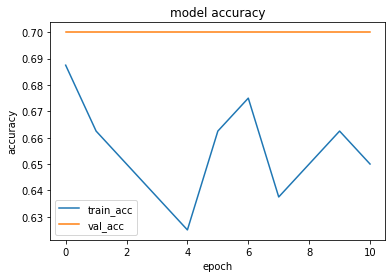

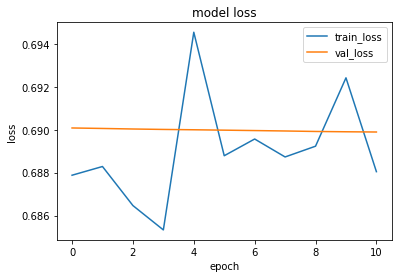

1it [00:00, 15141.89it/s]
file is another_control.mov, prediction is [[0.49866715]]
1it [00:00, 13189.64it/s]
file is short_armflapping.mov, prediction is [[0.5187626]]
1it [00:00, 17848.10it/s]
file is control_far.mov, prediction is [[0.49793783]]
1it [00:00, 17848.10it/s]
file is long_armflapping.mov, prediction is [[0.50116855]]
1it [00:00, 17476.27it/s]
file is me_reading_control.mov, prediction is [[0.4978103]]
1it [00:00, 15141.89it/s]
file is me_armflapping.mov, prediction is [[0.515734]]
Epoch 1/50
3/3 [==============================] - 0s 161ms/step - loss: 0.6853 - accuracy: 0.6125 - val_loss: 0.6972 - val_accuracy: 0.7000
Epoch 2/50
3/3 [==============================] - 0s 118ms/step - loss: 0.6864 - accuracy: 0.6875 - val_loss: 0.6972 - val_accuracy: 0.7000
Epoch 3/50
3/3 [==============================] - 0s 130ms/step - loss: 0.6885 - accuracy: 0.6000 - val_loss: 0.6972 - val_accuracy: 0.7000
Epoch 4/50
3/3 [==============================] - 0s 122ms/step - loss: 0.6858 

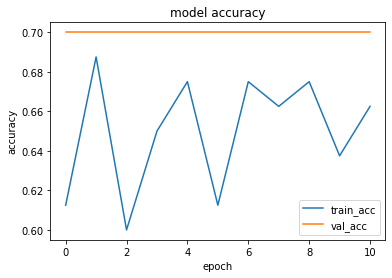

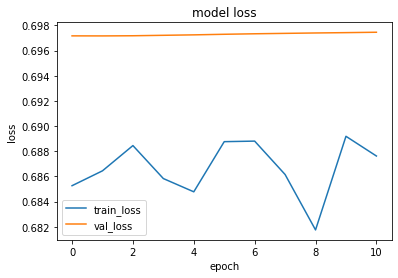

1it [00:00, 14716.86it/s]
file is another_control.mov, prediction is [[0.49892387]]
1it [00:00, 15887.52it/s]
file is short_armflapping.mov, prediction is [[0.51932764]]
1it [00:00, 9258.95it/s]
file is control_far.mov, prediction is [[0.4981341]]
1it [00:00, 17924.38it/s]
file is long_armflapping.mov, prediction is [[0.5015837]]
1it [00:00, 17476.27it/s]
file is me_reading_control.mov, prediction is [[0.49798945]]
1it [00:00, 14716.86it/s]
file is me_armflapping.mov, prediction is [[0.5165069]]
Epoch 1/50
3/3 [==============================] - 0s 158ms/step - loss: 0.6923 - accuracy: 0.6375 - val_loss: 0.6826 - val_accuracy: 0.7500
Epoch 2/50
3/3 [==============================] - 0s 122ms/step - loss: 0.6912 - accuracy: 0.6500 - val_loss: 0.6825 - val_accuracy: 0.7500
Epoch 3/50
3/3 [==============================] - 0s 131ms/step - loss: 0.6934 - accuracy: 0.5750 - val_loss: 0.6825 - val_accuracy: 0.7500
Epoch 4/50
3/3 [==============================] - 0s 126ms/step - loss: 0.6888 

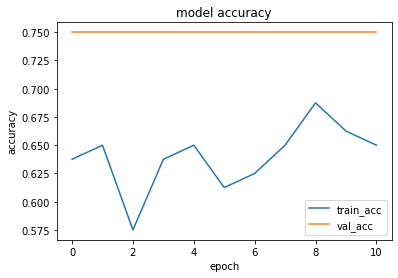

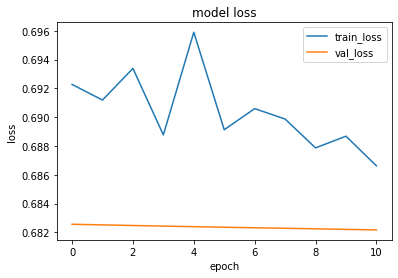

1it [00:00, 12052.60it/s]
file is another_control.mov, prediction is [[0.4989798]]
1it [00:00, 14716.86it/s]
file is short_armflapping.mov, prediction is [[0.51940846]]
1it [00:00, 11244.78it/s]
file is control_far.mov, prediction is [[0.49815863]]
1it [00:00, 19239.93it/s]
file is long_armflapping.mov, prediction is [[0.5017274]]
1it [00:00, 18893.26it/s]
file is me_reading_control.mov, prediction is [[0.49800032]]
1it [00:00, 18893.26it/s]file is me_armflapping.mov, prediction is [[0.516818]]
onto model 2



In [7]:
from copy import deepcopy
from tqdm import tqdm 
for z, model in enumerate([model_1, model_2]): 
    aug_model = deepcopy(model)
    aug_model.layers.insert(0, Augmenter()) # insert augmentation layer 
    assert model.layers != aug_model.layers
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, monitor="val_accuracy")

    patience = [5, 10]
    
    for i, test_model in enumerate([model, aug_model]):
        for learning_rate in [0.01, 0.001, 0.0005, 0.0001]:
            if z == 0: 
                test_model = tf.keras.models.Sequential([
                    tf.keras.layers.LSTM(16, return_sequences=False), 
                    tf.keras.layers.Dropout(0.2),
                    tf.keras.layers.Dense(1, activation="sigmoid")
                ])
            else: 
                test_model = tf.keras.models.Sequential([
                    tf.keras.layers.LSTM(8, return_sequences=False), 
                    tf.keras.layers.Dropout(0.2), 
                    tf.keras.layers.Dense(1, activation="sigmoid")
                ])

            test_model.compile(loss = 'binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics = ['accuracy'])    
            print(f"using {['no aug', 'aug'][i]} with lr {learning_rate}")
            try: 
                cross_validate(test_model, callbacks=[early_stopping, accuracy_callback])
            except Exception as e: 
                print(f"failed training because of {e}")
    print(f"onto model {z + 1}")

In [83]:
from tqdm import tqdm 

model = tf.keras.models.Sequential([
    Augmenter(), 
    tf.keras.layers.LSTM(32, return_sequences = False), 
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005), metrics = ['accuracy'])
cross_validate(model, epochs = 30, callbacks=[])

ValueError: zero-dimensional arrays cannot be concatenated

In [60]:
def generate_new_fold(num = 4):
    X_train = np.concatenate([X_j for j, X_j in enumerate(X) if j != num])
    y_train = np.concatenate([y_j for j, y_j in enumerate(y) if j != num]) # don't use the last one 
    X_test, y_test = X[num], y[num]
    return X_train, X_test, y_train, y_test 

X_train, X_test, y_train, y_test = generate_new_fold(num = 4)

In [42]:
def ensemble_val_acc(models, X_test, y_test): 
    y_pred = np.zeros_like(y_test)
    for model in models: 
        y_pred += model.predict(X_test).flatten()
    y_pred = y_pred / len(models)
    y_pred = np.round_(y_pred)
    return (y_pred == y_test).sum() / y_pred.shape[0]